#Librerías

In [ ]:
%%capture
!pip install pytorch-lightning pytorch-forecasting torch
!pip install prophet xgboost scikit-learn
!pip install neuralforecast

In [ ]:
# Google Colab
from google.colab import drive

# Estándar
import os

# Ciencia de datos y manipulación
import numpy as np
import pandas as pd

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Vacaciones
import holidays
from datetime import date

# modelos
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt
import pandas as pd

from sklearn.decomposition import PCA
from pytorch_forecasting import TimeSeriesDataSet

# Math
from math import sqrt

##Tunning
import optuna


##
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing

import joblib

RuntimeError: operator torchvision::nms does not exist

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_forecasting = pd.read_csv('/content/drive/MyDrive/ProyectosPython/Proyecto_Forescasting/AEP_hourly.csv')
df_forecasting.head()

Datetime   AEP_MW
0  2004-12-31 01:00:00  13478.0
1  2004-12-31 02:00:00  12865.0
2  2004-12-31 03:00:00  12577.0
3  2004-12-31 04:00:00  12517.0
4  2004-12-31 05:00:00  12670.0

In [ ]:
df_forecasting.rename(columns={'Datetime': 'fecha', 'AEP_MW': 'demanda'}, inplace=True)

#Realizando Feacture Temporales

In [ ]:
# Asegurar que la columna 'fecha' sea tipo datetime
df_forecasting['fecha'] = pd.to_datetime(df_forecasting['fecha'])

# Crear columnas nuevas con año, mes, día y hora
df_forecasting['anio'] = df_forecasting['fecha'].dt.year
df_forecasting['mes'] = df_forecasting['fecha'].dt.month
df_forecasting['dia'] = df_forecasting['fecha'].dt.day
df_forecasting['hora'] = df_forecasting['fecha'].dt.hour

df_forecasting['día_semana'] = df_forecasting['fecha'].dt.weekday

df_forecasting['anio'].value_counts().sort_index()

# Fin de semana
df_forecasting['es_fin_de_semana'] = df_forecasting['día_semana'].isin([5, 6]).astype(int)
# Periodo del día
def clasificar_periodo(hora):
    if 5 <= hora < 12:
        return 1
    elif 12 <= hora < 18:
        return 2
    elif 18 <= hora < 24:
        return 3
    else:
        return 0

df_forecasting['periodo_dia'] = df_forecasting['hora'].apply(clasificar_periodo)

# Semana del año

df_forecasting['semana'] = df_forecasting['fecha'].dt.isocalendar().week.astype(int)

# Trimestre

df_forecasting['trimestre'] = df_forecasting['fecha'].dt.quarter

# Cuatrimestre

df_forecasting['Cuatrimestre'] = df_forecasting['mes'].apply(lambda x: 1 if x <= 4 else (2 if x <= 8 else 3))

# Semestre

df_forecasting['semestre'] = df_forecasting['mes'].apply(lambda x: 1 if x <= 6 else 2)

# año bisiesto

df_forecasting['es_bisiesto'] = df_forecasting['anio'].apply(lambda x: 1 if (x % 4 == 0 and (x % 100 != 0 or x % 400 == 0)) else 0)

# Feriados
feriados_usa = holidays.US(years=range(df_forecasting['anio'].min(), df_forecasting['anio'].max()))

# Feriado
df_forecasting['es_feriado'] = df_forecasting['fecha'].dt.date.isin(feriados_usa).astype(int)


In [ ]:
df_forecasting_mes = df_forecasting.groupby(['anio', 'mes'])['demanda'].mean().reset_index()

In [ ]:
df_forecasting_mes['anio']= df_forecasting_mes['anio'].astype(str)
df_forecasting_mes['mes']= df_forecasting_mes['mes'].astype(str)

In [ ]:
df_forecasting_mes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   anio     167 non-null    object 
 1   mes      167 non-null    object 
 2   demanda  167 non-null    float64
dtypes: float64(1), object(2)
memory usage: 4.0+ KB


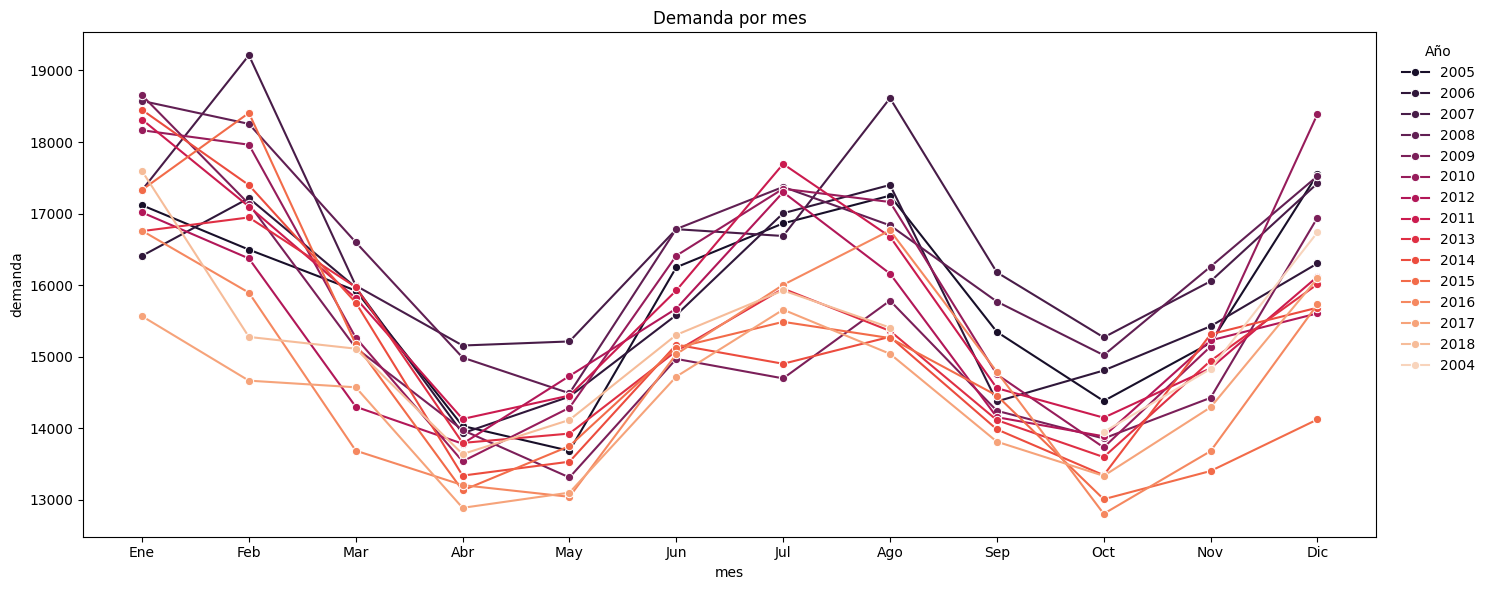

In [ ]:
df_forecasting_mes['mes'] = df_forecasting_mes['mes'].astype(int)

# Ordenar por mes
df_forecasting_mes = df_forecasting_mes.sort_values('mes')

# Graficar
plt.figure(figsize=(15, 6))
sns.lineplot(data=df_forecasting_mes, x='mes', y='demanda', hue='anio', palette="rocket", marker='o')

# Eje X con nombres de meses
plt.xticks(ticks=range(1, 13), labels=[
    "Ene", "Feb", "Mar", "Abr", "May", "Jun",
    "Jul", "Ago", "Sep", "Oct", "Nov", "Dic"
])

# Título
plt.title("Demanda por mes")

# Leyenda fuera del gráfico, sin fondo
plt.legend(title='Año', loc='upper left', bbox_to_anchor=(1.01, 1), frameon=False)

plt.tight_layout()
plt.show()

In [ ]:
df_forecasting_mes

anio  mes       demanda
3    2005    1  17117.088710
15   2006    1  16409.836022
27   2007    1  17328.814516
39   2008    1  18574.755376
51   2009    1  18653.024194
..    ...  ...           ...
98   2012   12  15605.911171
86   2011   12  16118.618280
158  2017   12  16094.728495
146  2016   12  15731.420699
134  2015   12  14123.189516

[167 rows x 3 columns]

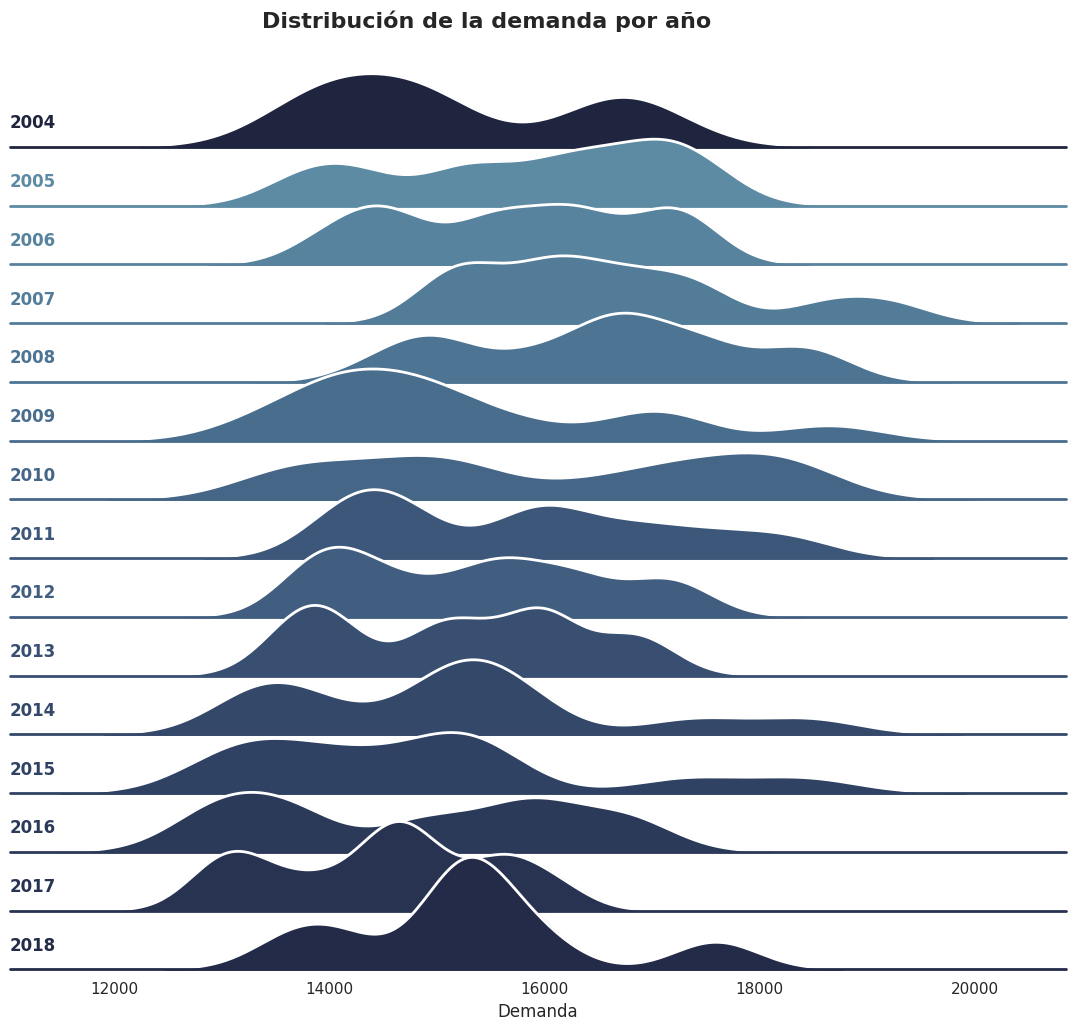

In [ ]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Asegúrate de que 'anio' sea tipo string (opcional, para mejor visualización)
df_forecasting_mes['anio'] = df_forecasting_mes['anio'].astype(str)

# Ordenar los años (si fuera necesario)
orden_anios = sorted(df_forecasting_mes['anio'].unique(), reverse=False)

# Crear paleta
pal = sns.cubehelix_palette(len(orden_anios), rot=-.25, light=.5)

# Crear el FacetGrid
g = sns.FacetGrid(df_forecasting_mes, row="anio", hue="anio",
                  aspect=15, height=.7, palette=pal, row_order=orden_anios)

# Graficar KDEs
g.map(sns.kdeplot, "demanda",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "demanda", clip_on=False, color="w", lw=2, bw_adjust=.5)

# Línea base
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# Etiquetas
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "demanda")

# Ajustes finales
g.figure.subplots_adjust(hspace=-.5)
g.set_titles("")
g.set(yticks=[], ylabel="", xlabel="Demanda")
g.despine(bottom=True, left=True)

plt.suptitle("Distribución de la demanda por año", fontsize=16, weight='bold')
g.figure.set_size_inches(12, len(orden_anios) * 0.7)
plt.show()


In [ ]:
df_forecasting_mes = df_forecasting_mes.sort_values(by=['anio', 'mes']).reset_index(drop=True)

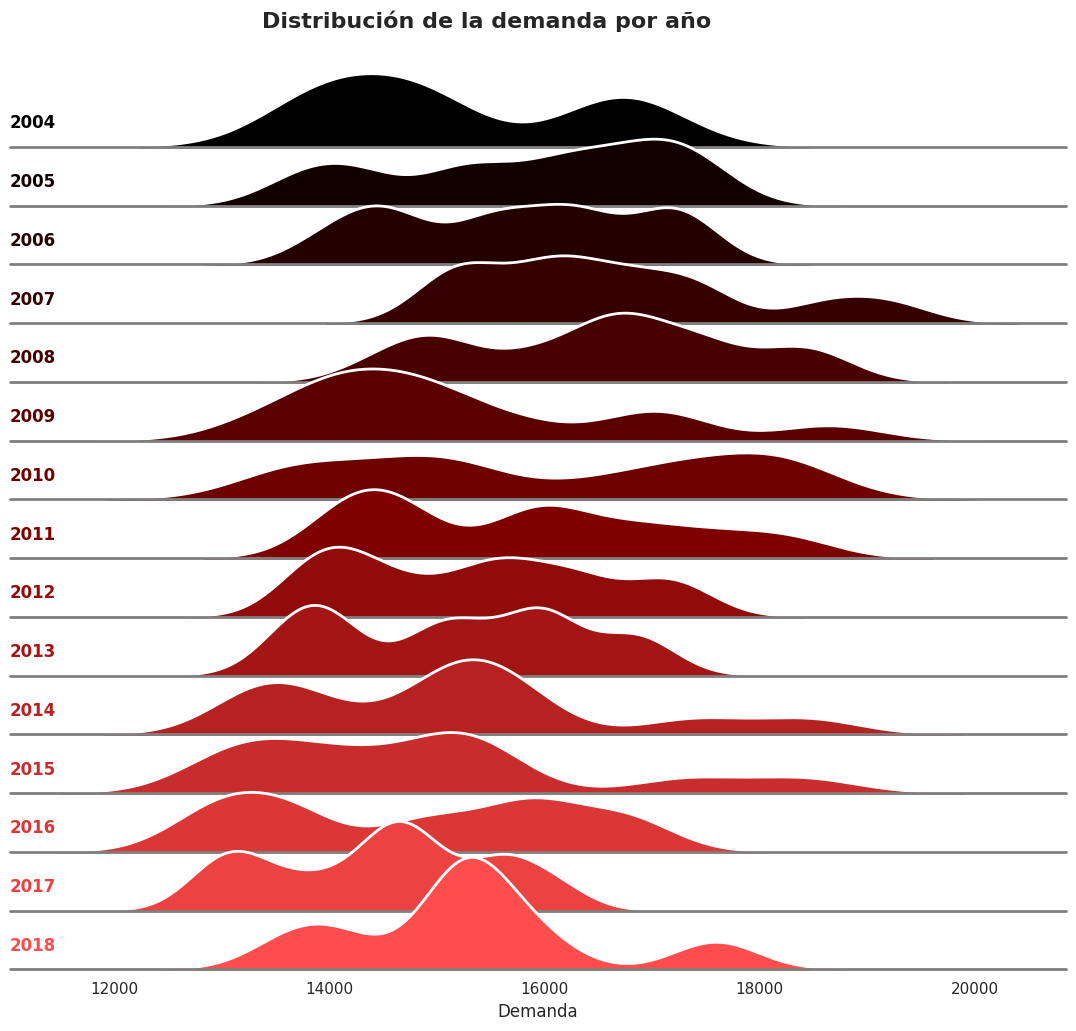

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Paleta personalizada: negro a rojo
colores_negro_rojo = LinearSegmentedColormap.from_list(
    "negro_rojo", ["black", "#800000", "#ff4d4d"], N=len(orden_anios)
)
pal = [colores_negro_rojo(i / (len(orden_anios)-1)) for i in range(len(orden_anios))]

sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Asegurar tipo string para 'anio'
df_forecasting_mes['anio'] = df_forecasting_mes['anio'].astype(str)
orden_anios = sorted(df_forecasting_mes['anio'].unique(), reverse=False)

# Crear el FacetGrid
g = sns.FacetGrid(df_forecasting_mes, row="anio", hue="anio",
                  aspect=15, height=.7, palette=pal, row_order=orden_anios)

# KDE con relleno y contorno blanco
g.map(sns.kdeplot, "demanda", bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "demanda", clip_on=False, color="w", lw=2, bw_adjust=.5)

# Línea base
g.refline(y=0, linewidth=2, linestyle="-", clip_on=False)

# Etiquetas
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "demanda")

# Ajustes finales
g.figure.subplots_adjust(hspace=-.5)
g.set_titles("")
g.set(yticks=[], ylabel="", xlabel="Demanda")
g.despine(bottom=True, left=True)

plt.suptitle("Distribución de la demanda por año", fontsize=16, weight='bold')
g.figure.set_size_inches(12, len(orden_anios) * 0.7)
plt.show()



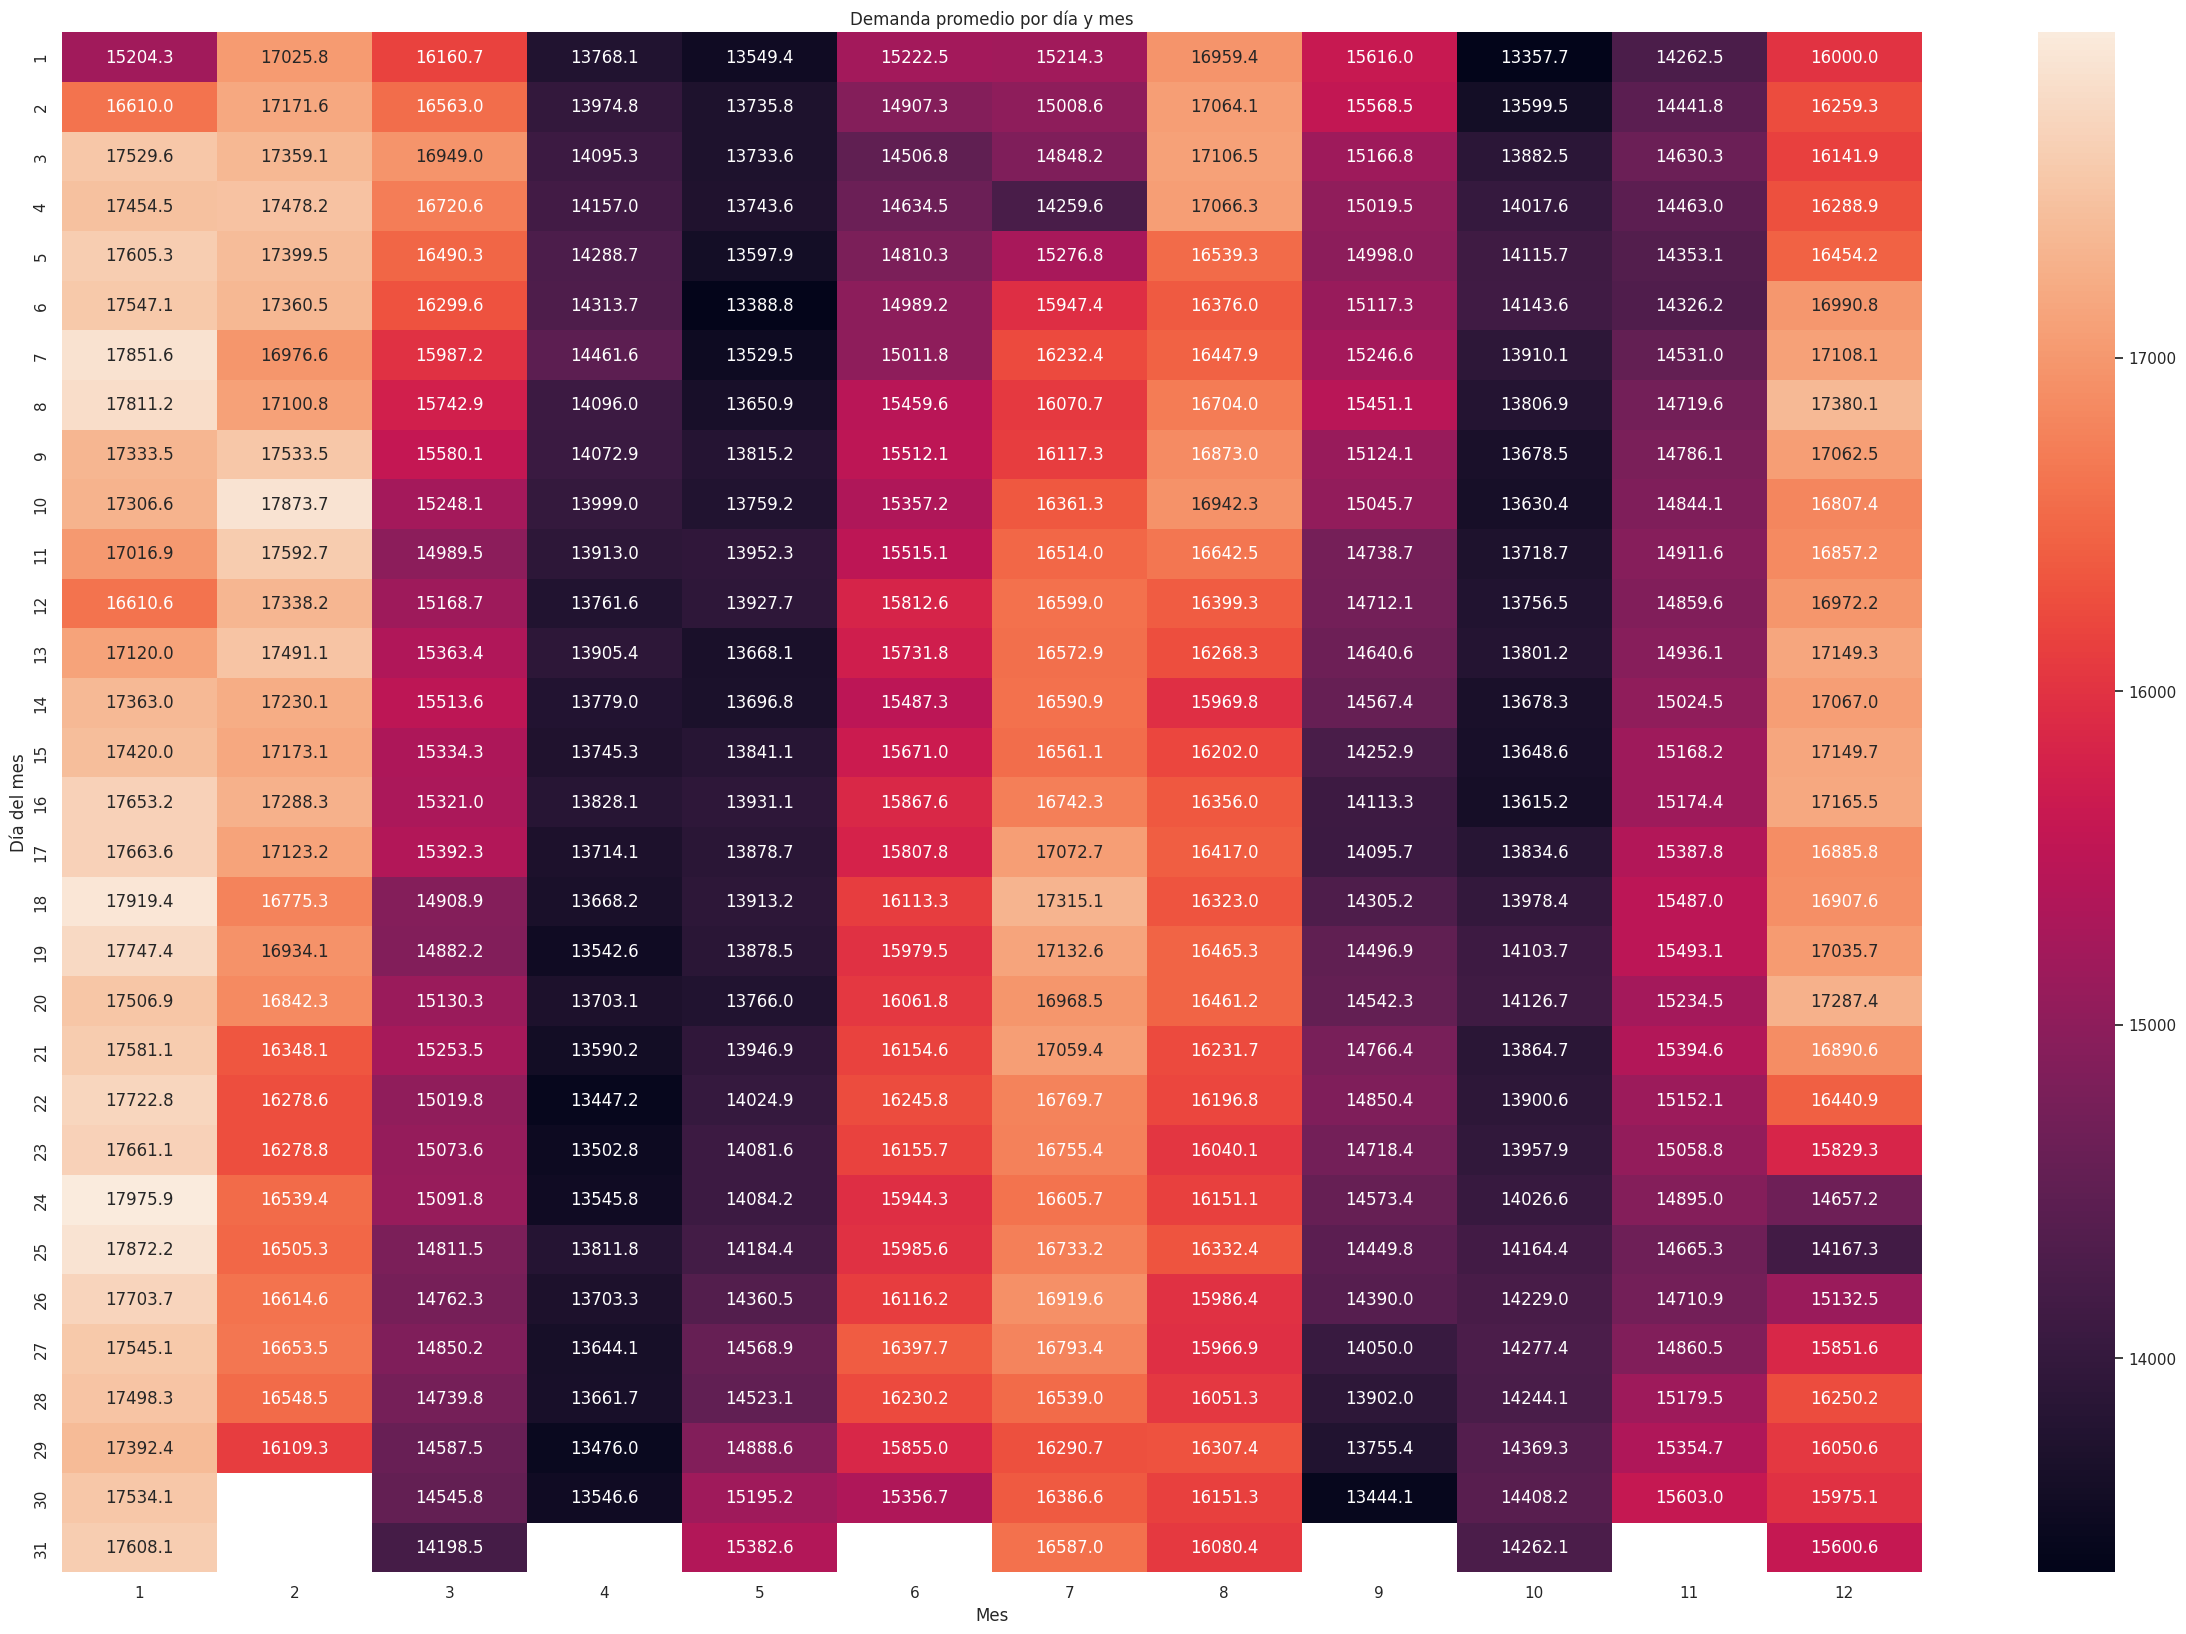

In [ ]:
# Agrupar para obtener la demanda promedio por mes y día
pivot = df_forecasting.groupby(['dia', 'mes'])['demanda'].mean().reset_index()
tabla = pivot.pivot(index='dia', columns='mes', values='demanda')

# Crear heatmap
plt.figure(figsize=(30, 20))
sns.heatmap(tabla, cmap='rocket', annot=True, fmt=".1f")
plt.title("Demanda promedio por día y mes")
plt.ylabel("Día del mes")
plt.xlabel("Mes")
plt.show()


Text(0.5, 1.0, 'Correlation Heatmap')

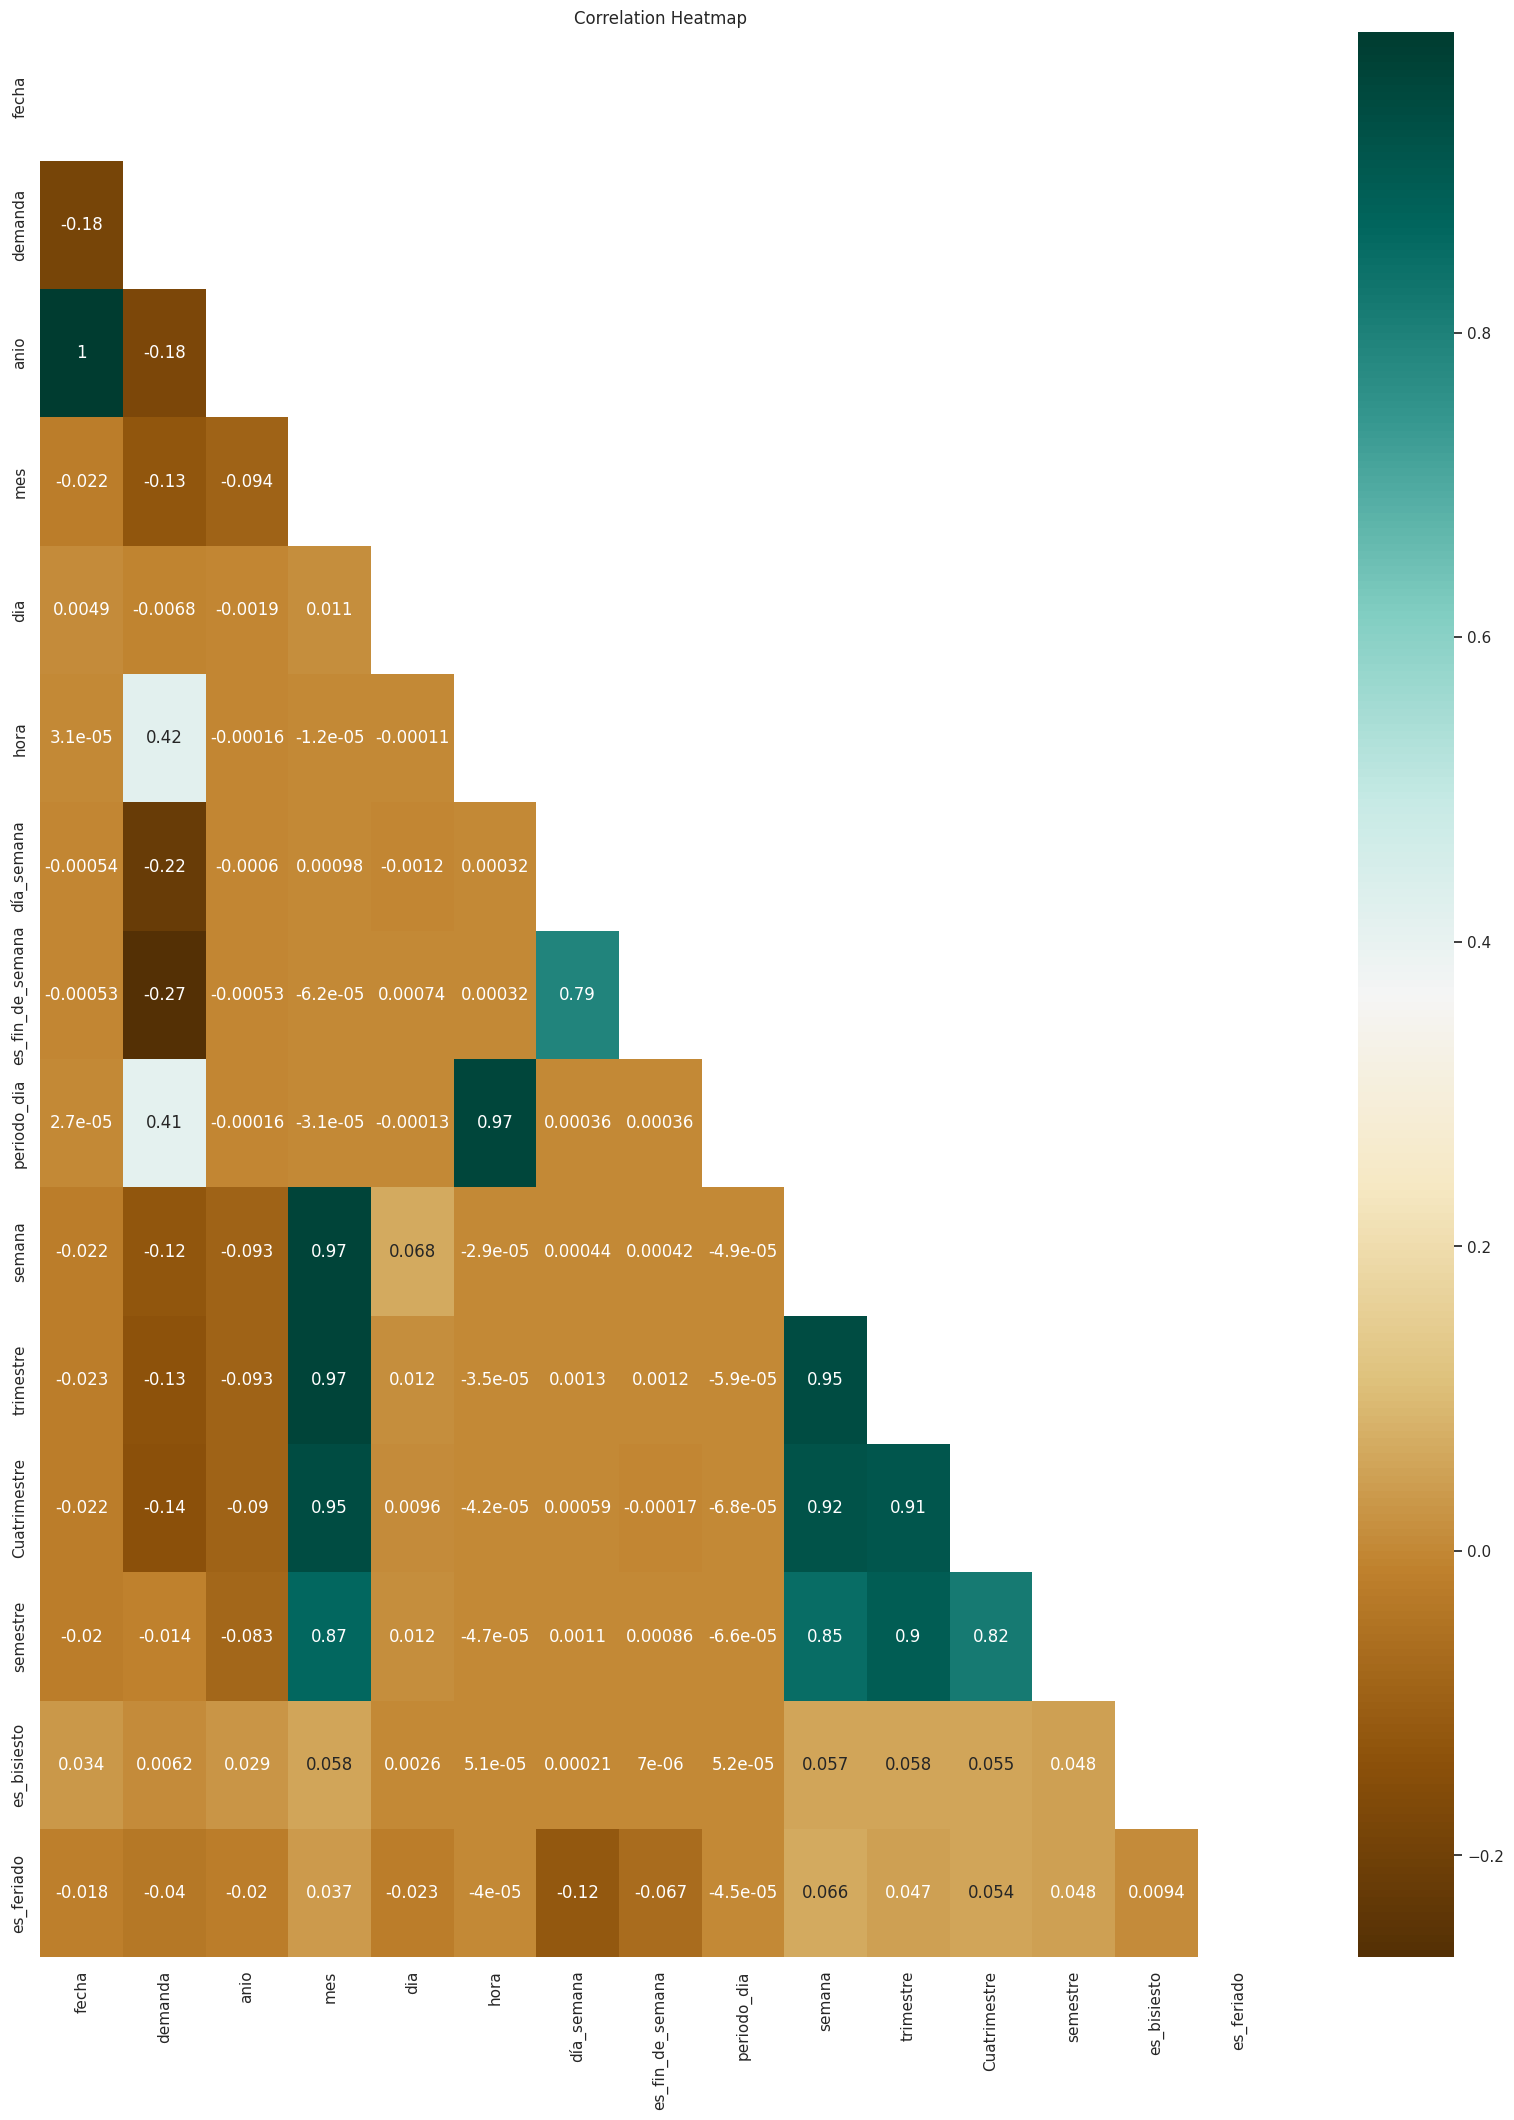

In [ ]:
# Crear figura y heatmap
plt.figure(figsize=(20, 25))
sns.heatmap(data=df_forecasting.corr(), mask=np.triu(df_forecasting.corr()), annot=True, cmap='BrBG')
plt.title('Correlation Heatmap')

# # Guardar imagen
# ruta_heatmap = "/content/drive/MyDrive/ProyectosPython/Proyecto_Mantenimiento/reports/figures/heatmap_correlacion.png"
# plt.savefig(ruta_heatmap, dpi=150, bbox_inches='tight')
# plt.close()  # Cierra para evitar doble renderizado

# # Mostrar imagen en Colab
# display(IPImage(filename=ruta_heatmap))

In [ ]:
features_minimos = ['hora', 'periodo_dia','es_fin_de_semana', 'anio']

In [ ]:
columnas_numericas=df_forecasting.select_dtypes(include=['number']).columns.drop('demanda').tolist()

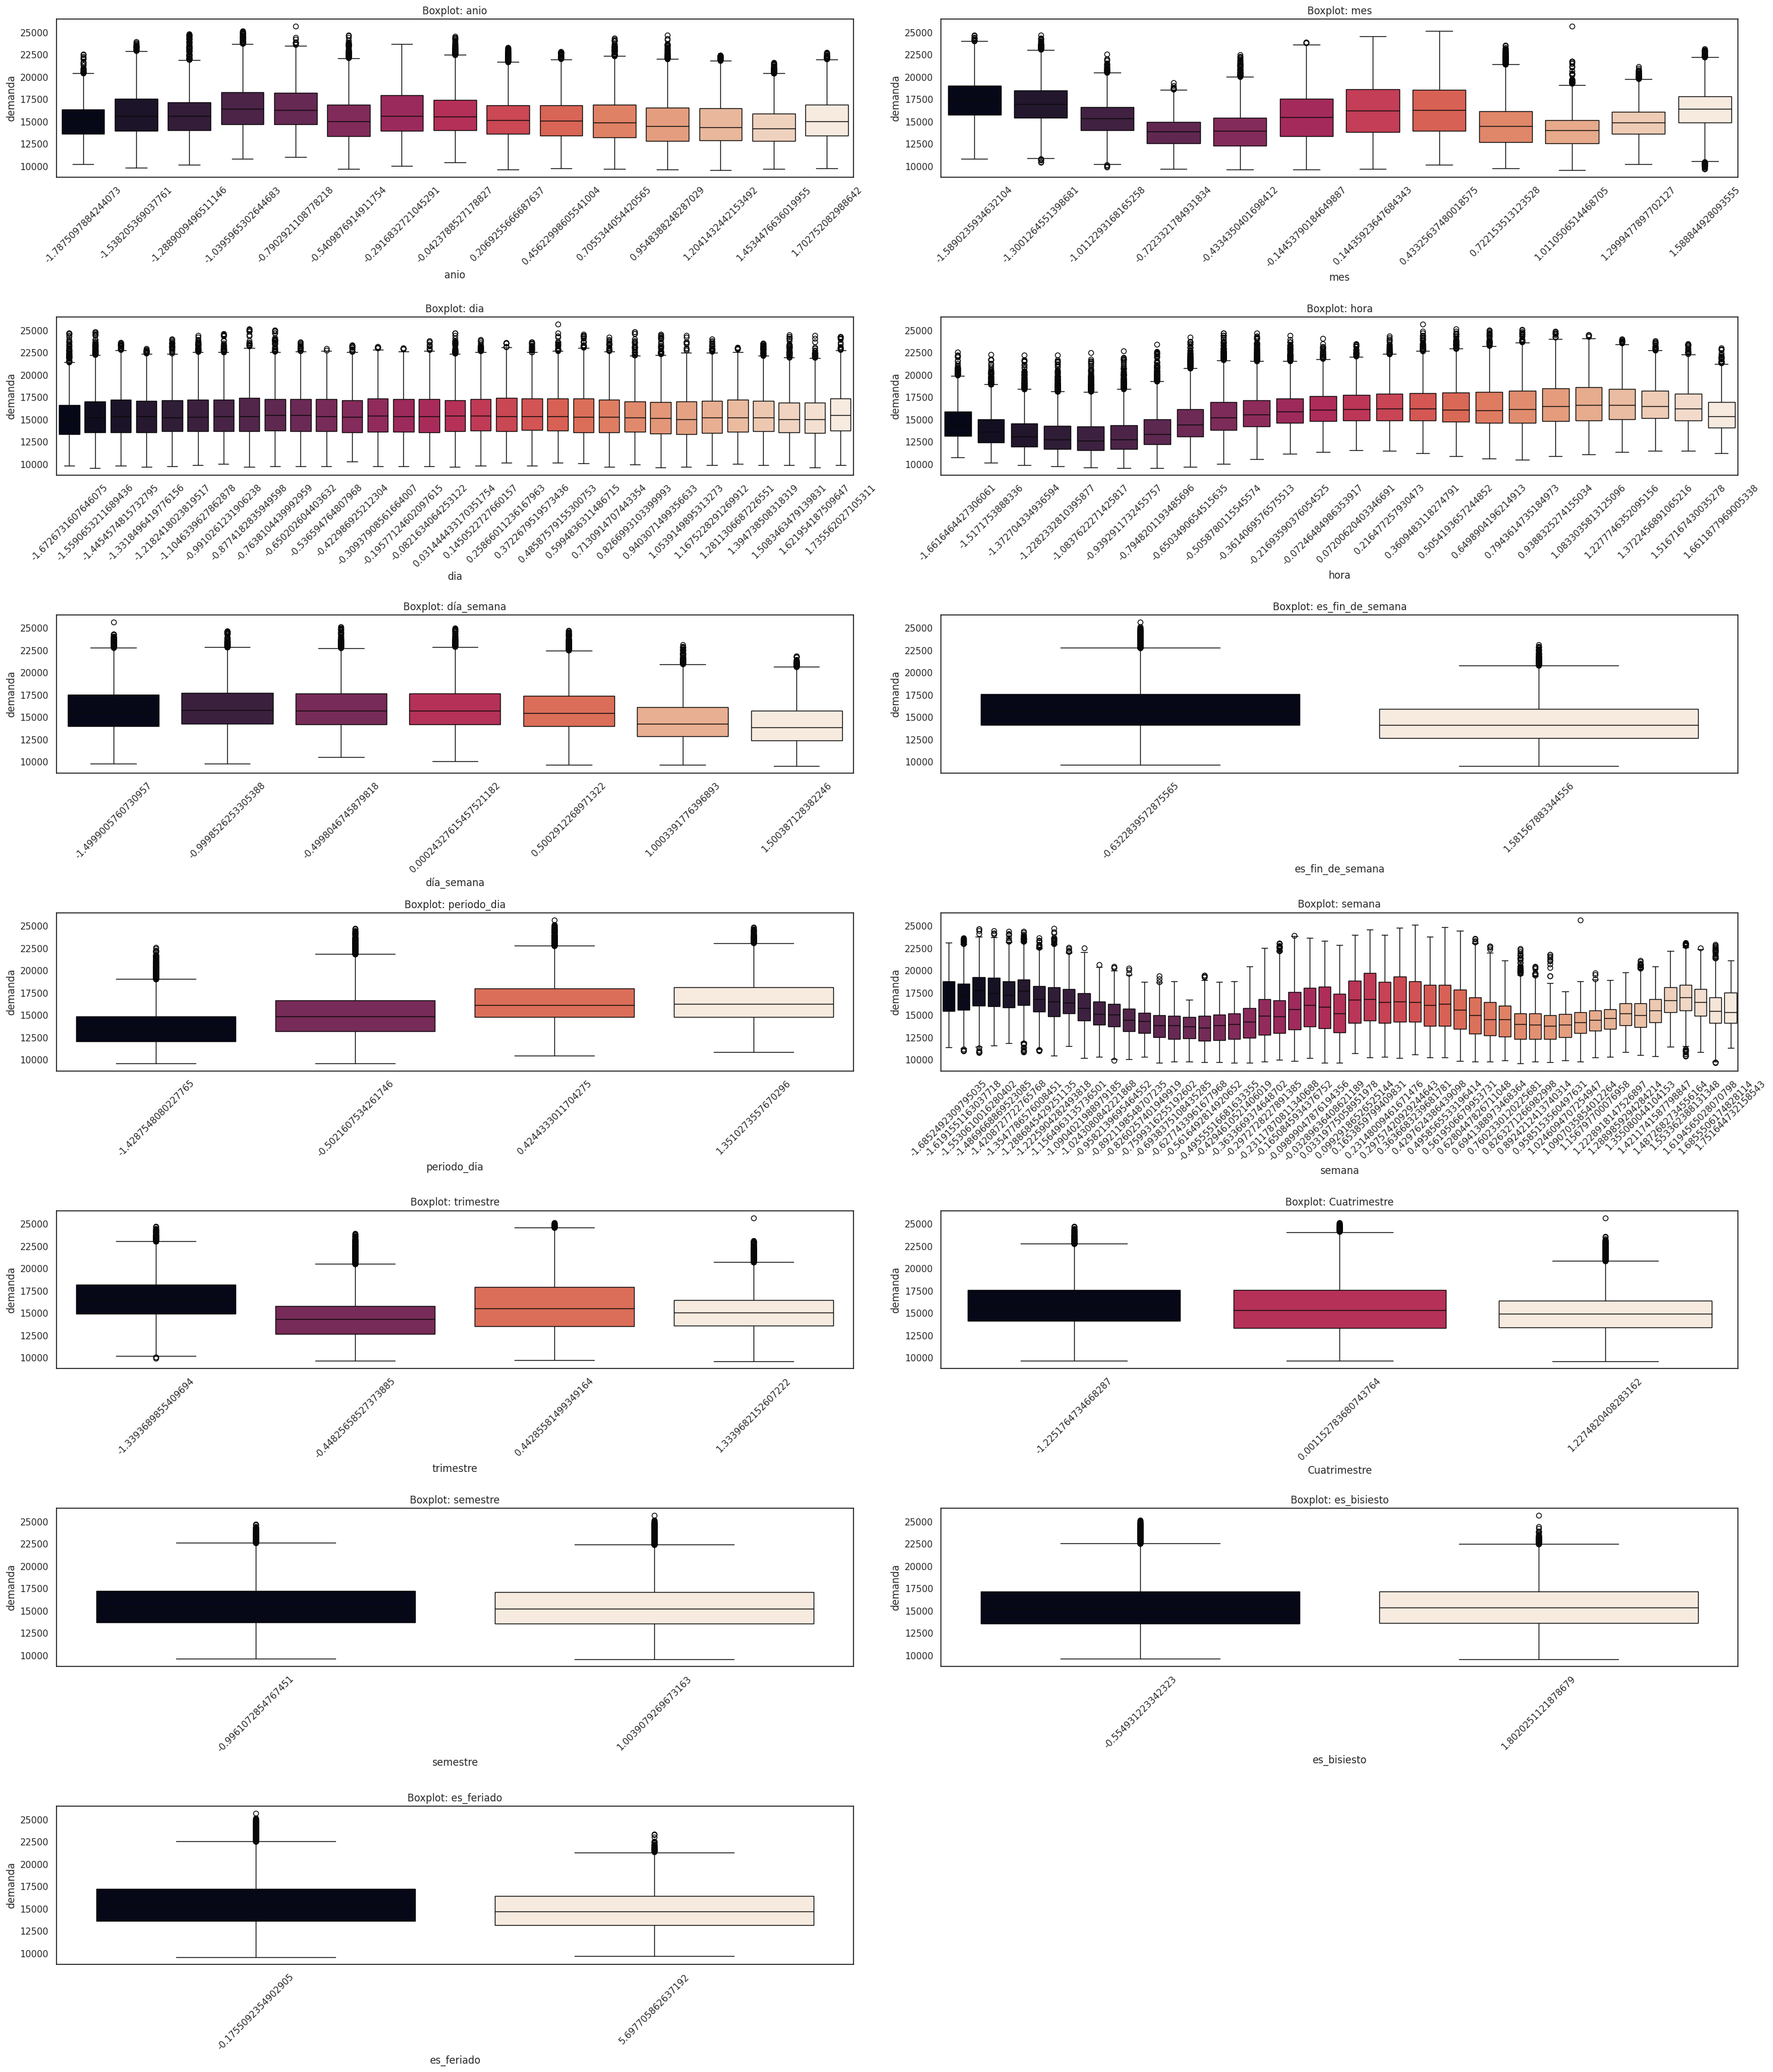

In [ ]:
n = len(columnas_numericas)
ncols = 2  # Número de columnas
nrows = -(-n // ncols)  # Redondeo hacia arriba (ceil)

# Crear subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15 * ncols, 5 * nrows))
axes = axes.flatten()  # Aplanar matriz de ejes para iterar fácilmente

# Graficar cada boxplot en su subplot
for i, feature in enumerate(columnas_numericas):
    sns.boxplot(data=df_forecasting, x=feature, y='demanda', hue=feature, ax=axes[i], palette='rocket', legend=False)
   # sns.stripplot(data=df_forecasting, x=feature, y='demanda', hue=feature, ax=axes[i])
    axes[i].set_title(f'Boxplot: {feature}')
    axes[i].tick_params(axis='x', rotation=45)  # Rotar etiquetas del eje X

# Eliminar subplots vacíos si los hay
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [ ]:
sc = StandardScaler()
df_forecasting_sinescalar=df_forecasting.copy()
# Aplicar StandardScaler solo a las columnas numéricas
df_forecasting[columnas_numericas] = sc.fit_transform(df_forecasting[columnas_numericas])

## PCA

In [ ]:
pca = PCA(n_components=len(features_minimos))
X_pca = pd.DataFrame(data=pca.fit_transform(df_forecasting[features_minimos]), columns=['PC'+str(i+1) for i in range(len(features_minimos))])
var_exp = pd.Series(data=100*pca.explained_variance_ratio_, index=['PC'+str(i+1) for i in range(len(features_minimos))])
print('Explained variance ratio per component:', round(var_exp,2), sep='\n')
print('Explained variance ratio with 3 components: '+str(round(var_exp.values[:7].sum(),2)))

Explained variance ratio per component:
PC1    49.19
PC2    25.01
PC3    24.99
PC4     0.81
dtype: float64
Explained variance ratio with 3 components: 100.0


In [ ]:
pca = PCA(n_components=len(columnas_numericas))
X_pca = pd.DataFrame(data=pca.fit_transform(df_forecasting[columnas_numericas]), columns=['PC'+str(i+1) for i in range(len(columnas_numericas))])
var_exp = pd.Series(data=100*pca.explained_variance_ratio_, index=['PC'+str(i+1) for i in range(len(columnas_numericas))])
print('Explained variance ratio per component:', round(var_exp,2), sep='\n')
print('Explained variance ratio with 3 components: '+str(round(var_exp.values[:7].sum(),2)))

Explained variance ratio per component:
PC1     35.88
PC2     15.14
PC3     13.94
PC4      7.92
PC5      7.81
PC6      7.47
PC7      7.28
PC8      1.61
PC9      1.60
PC10     0.62
PC11     0.34
PC12     0.25
PC13     0.13
dtype: float64
Explained variance ratio with 3 components: 95.45


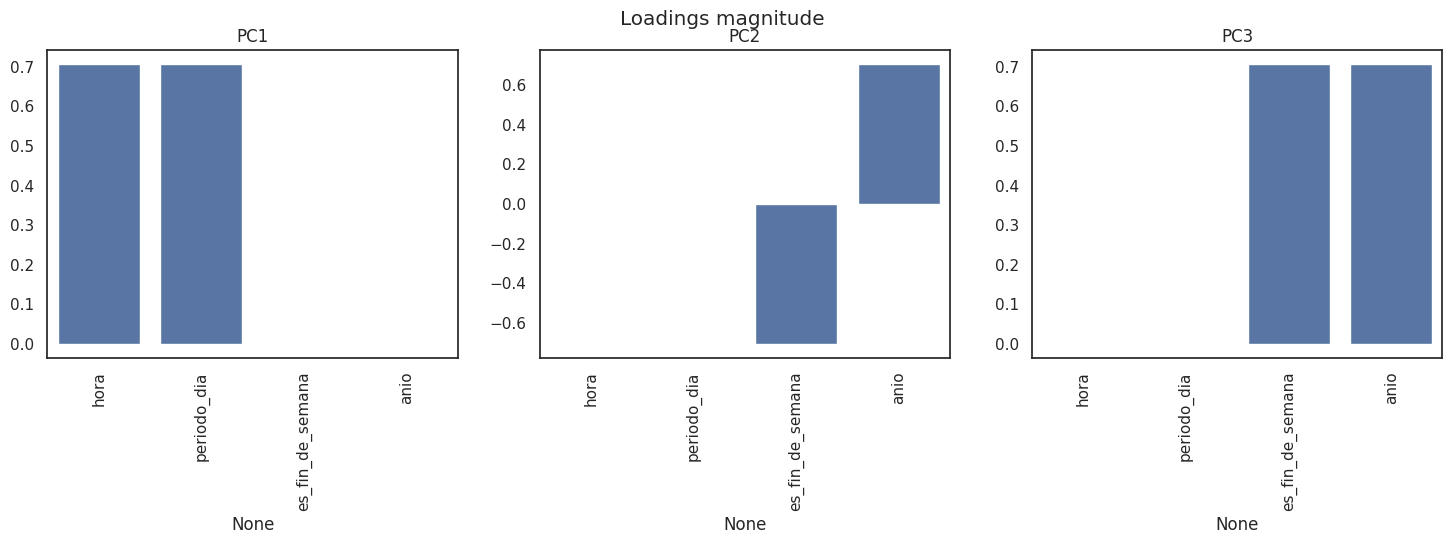

In [ ]:
# PCA for Data visualization
pca3 = PCA(n_components=3)
X_pca3 = pd.DataFrame(data=pca3.fit_transform(df_forecasting[features_minimos]), columns=['PC1','PC2','PC3'])

# Loadings Analysis
fig, axs = plt.subplots(ncols=3, figsize=(18,4))
fig.suptitle('Loadings magnitude')
pca_loadings = pd.DataFrame(data=pca3.components_, columns=features_minimos)
for j in range(3):
    ax = axs[j]
    sns.barplot(ax=ax, x=pca_loadings.columns, y=pca_loadings.values[j])
    ax.tick_params(axis='x', rotation=90)
    ax.title.set_text('PC'+str(j+1))
plt.show()

In [ ]:
df_forecasting.columns

Index(['fecha', 'demanda', 'anio', 'mes', 'dia', 'hora', 'día_semana',
       'es_fin_de_semana', 'periodo_dia', 'semana', 'trimestre',
       'Cuatrimestre', 'semestre', 'es_bisiesto', 'es_feriado'],
      dtype='object')

# Modelos

In [ ]:
# Ver cuántas fechas están duplicadas
duplicados = df_forecasting['fecha'].duplicated().sum()
print(f"Fechas duplicadas: {duplicados}")

Fechas duplicadas: 4


In [ ]:
# Agrupar por hora si hay múltiples valores por hora
df = df_forecasting.copy()
df['fecha'] = pd.to_datetime(df['fecha'])

df = df.groupby('fecha').mean(numeric_only=True).asfreq('h')
df = df.dropna()
df = df.sort_index()
# Separar train/test
horizonte_pred = 24 * 7  # última semana para prueba
train = df.iloc[:-horizonte_pred]
test = df.iloc[-horizonte_pred:]

In [72]:
test

demanda      anio       mes       dia      hora  \
fecha                                                                  
2018-07-27 01:00:00  14057.0  1.702752  0.144359  1.281131 -1.517175   
2018-07-27 02:00:00  13320.0  1.702752  0.144359  1.281131 -1.372704   
2018-07-27 03:00:00  12846.0  1.702752  0.144359  1.281131 -1.228233   
2018-07-27 04:00:00  12512.0  1.702752  0.144359  1.281131 -1.083762   
2018-07-27 05:00:00  12533.0  1.702752  0.144359  1.281131 -0.939291   
...                      ...       ...       ...       ...       ...   
2018-08-02 20:00:00  17673.0  1.702752  0.433256 -1.559065  1.227775   
2018-08-02 21:00:00  17303.0  1.702752  0.433256 -1.559065  1.372246   
2018-08-02 22:00:00  17001.0  1.702752  0.433256 -1.559065  1.516717   
2018-08-02 23:00:00  15964.0  1.702752  0.433256 -1.559065  1.661188   
2018-08-03 00:00:00  14809.0  1.702752  0.433256 -1.445457 -1.661646   

                     día_semana  es_fin_de_semana  periodo_dia    semana  \
fecha                                                                      
2018-07-27 01:00:00    0.500291         -0.632284    -1.428755  0.231480   
2018-07-27 02:00:00    0.500291         -0.632284    -1.428755  0.231480   
2018-07-27 03:00:00    0.500291         -0.632284    -1.428755  0.231480   
2018-07-27 04:00:00    0.500291         -0.632284    -1.428755  0.231480   
2018-07-27 05:00:00    0.500291         -0.632284    -0.502161  0.231480   
...                         ...               ...          ...       ...   
2018-08-02 20:00:00    0.000243         -0.632284     1.351027  0.297574   
2018-08-02 21:00:00    0.000243         -0.632284     1.351027  0.297574   
2018-08-02 22:00:00    0.000243         -0.632284     1.351027  0.297574   
2018-08-02 23:00:00    0.000243         -0.632284     1.351027  0.297574   
2018-08-03 00:00:00    0.500291         -0.632284    -1.428755  0.297574   

                     trimestre  Cuatrimestre  semestre  es_bisiesto  \
fecha                                                                 
2018-07-27 01:00:00   0.442856      0.001153  1.003908    -0.554931   
2018-07-27 02:00:00   0.442856      0.001153  1.003908    -0.554931   
2018-07-27 03:00:00   0.442856      0.001153  1.003908    -0.554931   
2018-07-27 04:00:00   0.442856      0.001153  1.003908    -0.554931   
2018-07-27 05:00:00   0.442856      0.001153  1.003908    -0.554931   
...                        ...           ...       ...          ...   
2018-08-02 20:00:00   0.442856      0.001153  1.003908    -0.554931   
2018-08-02 21:00:00   0.442856      0.001153  1.003908    -0.554931   
2018-08-02 22:00:00   0.442856      0.001153  1.003908    -0.554931   
2018-08-02 23:00:00   0.442856      0.001153  1.003908    -0.554931   
2018-08-03 00:00:00   0.442856      0.001153  1.003908    -0.554931   

                     es_feriado  
fecha                            
2018-07-27 01:00:00   -0.175509  
2018-07-27 02:00:00   -0.175509  
2018-07-27 03:00:00   -0.175509  
2018-07-27 04:00:00   -0.175509  
2018-07-27 05:00:00   -0.175509  
...                         ...  
2018-08-02 20:00:00   -0.175509  
2018-08-02 21:00:00   -0.175509  
2018-08-02 22:00:00   -0.175509  
2018-08-02 23:00:00   -0.175509  
2018-08-03 00:00:00   -0.175509  

[168 rows x 14 columns]

##Modelo Hot-Winter

In [ ]:
def evaluar(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return {"RMSE": rmse, "MAE": mae, "MAPE": mape}

In [ ]:


def ejecutar_modelo_holtwinters(train, test, horizonte_pred):
    try:
        freq = pd.infer_freq(train.index)
        if freq:
            train = train.asfreq(freq)

        model_hw = ExponentialSmoothing(
            train['demanda'],
            trend='add',
            seasonal='add',
            seasonal_periods=24,
            initialization_method="legacy-heuristic"
        )
        fit_hw = model_hw.fit()
        pred_hw = fit_hw.forecast(horizonte_pred)

        if pred_hw.isna().sum() == 0:
            return evaluar(test['demanda'].values[:horizonte_pred], pred_hw.values), pred_hw, fit_hw
        else:
            raise ValueError("Predicción HW contiene NaNs")

    except Exception as e:
        print(f"⚠️ Error en Holt-Winters: {e}")
        return {"RMSE": np.nan, "MAE": np.nan, "MAPE": np.nan}, None, None

In [ ]:
metricas_hw, pred_hw, modelo_hw = ejecutar_modelo_holtwinters(train, test, horizonte_pred)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a support

In [ ]:
ruta_modelo = '/content/drive/MyDrive/ProyectosPython/Proyecto_Forescasting/modelos/modeloclasico/holtwinter'

# Crear la carpeta si no existe
os.makedirs(ruta_modelo, exist_ok=True)

# Guardar el modelo con nombre 'modelo_hw.pkl'
joblib.dump((metricas_hw, pred_hw, modelo_hw), os.path.join(ruta_modelo, 'modelo_completo_hw.pkl'))

['/content/drive/MyDrive/ProyectosPython/Proyecto_Forescasting/modelos/modeloclasico/holtwinter/modelo_completo_hw.pkl']

In [ ]:
ruta_modelo = '/content/drive/MyDrive/ProyectosPython/Proyecto_Forescasting/modelos/modeloclasico/holtwinter'

In [ ]:
metricas_hw_extr, pred_hw_ext, modelo_hw_ext = joblib.load(os.path.join(ruta_modelo, 'modelo_completo.pkl'))

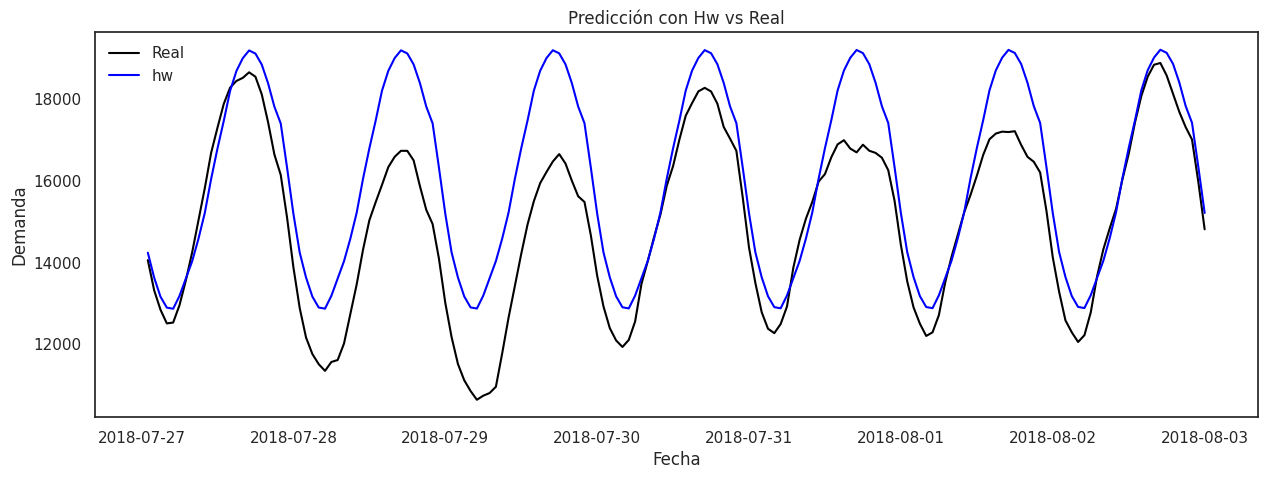

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(test.index, test['demanda'], label='Real', color='black')
plt.plot(test.index, pred_hw_ext, label='hw', color='blue')
plt.legend()
plt.title("Predicción con Hw vs Real")
plt.legend(frameon=False)
plt.xlabel("Fecha")
plt.ylabel("Demanda")
plt.show()

##Prophet

In [ ]:
def ejecutar_modelo_prophet(train, test, horizonte_pred):
    from prophet import Prophet
    import pandas as pd

    try:
        # Preparar datos
        df_prophet = train.reset_index()[['fecha', 'demanda']].rename(columns={'fecha': 'ds', 'demanda': 'y'})

        model = Prophet()
        model.fit(df_prophet)

        # Crear fechas futuras
        future = model.make_future_dataframe(periods=horizonte_pred, freq='h')
        forecast = model.predict(future)

        # Filtrar solo las fechas del test
        pred_prophet = forecast.set_index('ds').loc[test.index, 'yhat']

        # Validar si hay NaNs
        if pred_prophet.isna().sum() == 0:
            return evaluar(test['demanda'], pred_prophet), pred_prophet, model
        else:
            raise ValueError("Predicción Prophet contiene NaNs")

    except Exception as e:
        print(f"⚠️ Error en Prophet: {e}")
        return {"RMSE": np.nan, "MAE": np.nan, "MAPE": np.nan}, None, None

metricas_prophet, pred_prophet, prophet_model = ejecutar_modelo_prophet(train, test, horizonte_pred)


DEBUG:cmdstanpy:input tempfile: /tmp/tmph0nts1cs/_8hvaffn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph0nts1cs/lh6y1983.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61942', 'data', 'file=/tmp/tmph0nts1cs/_8hvaffn.json', 'init=/tmp/tmph0nts1cs/lh6y1983.json', 'output', 'file=/tmp/tmph0nts1cs/prophet_model43o4cq74/prophet_model-20250629233123.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:31:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:35:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
ruta_modelo = '/content/drive/MyDrive/ProyectosPython/Proyecto_Forescasting/modelos/modeloclasico/prophet'

In [ ]:

# Crear la carpeta si no existe
os.makedirs(ruta_modelo, exist_ok=True)

# Guardar el modelo con nombre 'modelo_hw.pkl'
joblib.dump((metricas_prophet, pred_prophet, prophet_model), os.path.join(ruta_modelo, 'modelo_completo_prophet.pkl'))

['/content/drive/MyDrive/ProyectosPython/Proyecto_Forescasting/modelos/modeloclasico/prophet/modelo_completo.pkl']

In [ ]:

metricas_prophet_extr, pred_prophet_ext, modelo_prophet_ext = joblib.load(os.path.join(ruta_modelo, 'modelo_completo.pkl'))

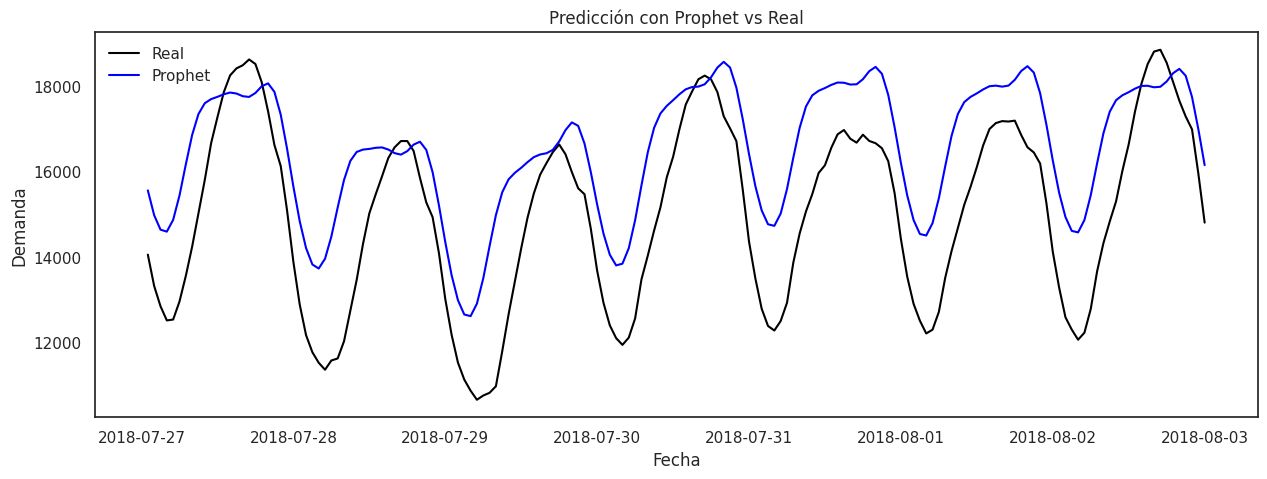

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(test.index, test['demanda'], label='Real', color='black')
plt.plot(test.index, pred_prophet_ext, label='Prophet', color='blue')
plt.legend(frameon=False)
plt.title("Predicción con Prophet vs Real")
plt.xlabel("Fecha")
plt.ylabel("Demanda")
plt.show()

##Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

def ejecutar_modelo_random_forest(train, test, features, horizonte_pred):
    try:
        # Validar que no haya NaNs
        if train[features + ['demanda']].isna().sum().sum() > 0 or test[features].isna().sum().sum() > 0:
            raise ValueError("Hay NaNs en train o test")

        # Separar variables independientes y dependiente
        X_train = train[features]
        y_train = train['demanda']
        X_test = test[features]

        # Entrenar modelo
        modelo_rf = RandomForestRegressor(n_estimators=100, random_state=42)
        modelo_rf.fit(X_train, y_train)

        # Predecir
        pred_rf = modelo_rf.predict(X_test)

        # Evaluar
        metricas_rf = evaluar(test['demanda'], pred_rf)
        return metricas_rf, pred_rf, modelo_rf

    except Exception as e:
        print(f"⚠️ Error en Random Forest: {e}")
        return {"RMSE": np.nan, "MAE": np.nan, "MAPE": np.nan}, None, None

features = ['anio', 'mes', 'dia', 'hora', 'día_semana',
            'es_fin_de_semana', 'periodo_dia', 'semana', 'trimestre',
            'Cuatrimestre', 'semestre', 'es_bisiesto', 'es_feriado']

metricas_rf, pred_rf, modelo_rf = ejecutar_modelo_random_forest(train, test, features, horizonte_pred)

In [ ]:


# Crear la carpeta si no existe
os.makedirs(ruta_modelo, exist_ok=True)

# Guardar el modelo con nombre 'modelo_hw.pkl'
joblib.dump((metricas_rf, pred_rf, modelo_rf), os.path.join(ruta_modelo, 'modelo_completo_rf.pkl'))

['/content/drive/MyDrive/ProyectosPython/Proyecto_Forescasting/modelos/modeloclasico/randomforest/modelo_completo.pkl']

In [64]:
metricas_prophet_extr, pred_prophet_ext, modelo_prophet_ext = joblib.load(os.path.join(ruta_modelo, 'modelo_completo.pkl'))

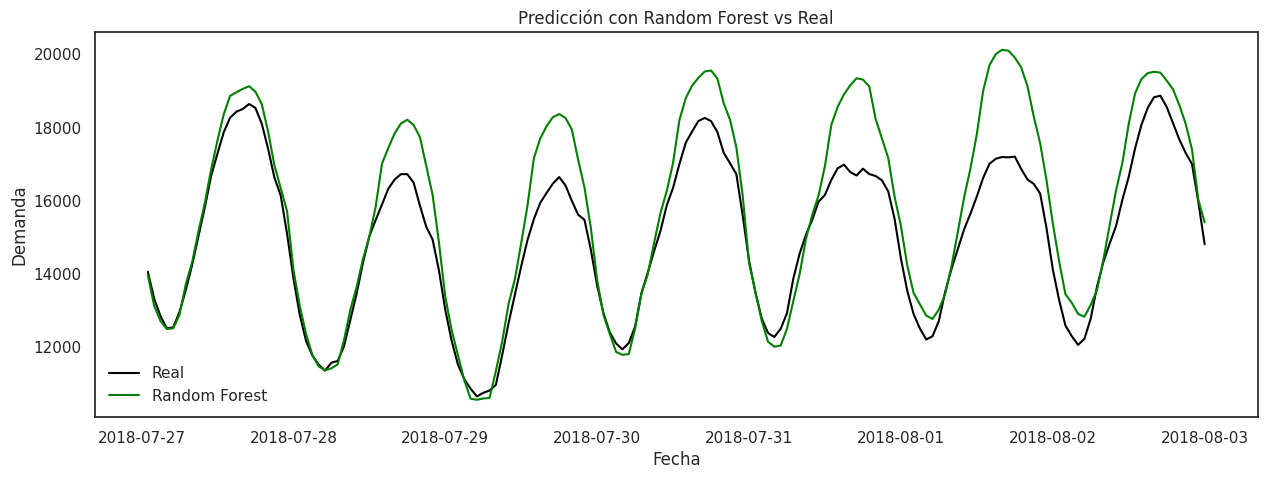

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(test.index, test['demanda'], label='Real', color='black')
plt.plot(test.index, pred_rf, label='Random Forest', color='green')
plt.legend(frameon=False)
plt.title("Predicción con Random Forest vs Real")
plt.xlabel("Fecha")
plt.ylabel("Demanda")
plt.show()

##XGBOOTS

In [ ]:
from xgboost import XGBRegressor

def ejecutar_modelo_xgboost(train, test, features, horizonte_pred):
    try:
        # Validar datos faltantes
        if train[features + ['demanda']].isna().sum().sum() > 0 or test[features].isna().sum().sum() > 0:
            raise ValueError("Hay NaNs en train o test")

        # Datos de entrada
        X_train = train[features]
        y_train = train['demanda']
        X_test = test[features]

        # Modelo
        modelo_xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
        modelo_xgb.fit(X_train, y_train)

        # Predicción
        pred_xgb = modelo_xgb.predict(X_test)

        # Evaluación
        metricas_xgb = evaluar(test['demanda'], pred_xgb)
        return metricas_xgb, pred_xgb, modelo_xgb

    except Exception as e:
        print(f"⚠️ Error en XGBoost: {e}")
        return {"RMSE": np.nan, "MAE": np.nan, "MAPE": np.nan}, None, None

features = ['anio', 'mes', 'dia', 'hora', 'día_semana',
            'es_fin_de_semana', 'periodo_dia', 'semana', 'trimestre',
            'Cuatrimestre', 'semestre', 'es_bisiesto', 'es_feriado']

metricas_xgb, pred_xgb, modelo_xgb = ejecutar_modelo_xgboost(train, test, features, horizonte_pred)

In [ ]:
ruta_modelo = '/content/drive/MyDrive/ProyectosPython/Proyecto_Forescasting/modelos/modeloclasico/xgboots'

# Crear la carpeta si no existe
os.makedirs(ruta_modelo, exist_ok=True)

# Guardar el modelo con nombre 'modelo_xgb.pkl'
joblib.dump((metricas_xgb, pred_xgb, modelo_xgb), os.path.join(ruta_modelo, 'modelo_completo_xgb.pkl'))

['/content/drive/MyDrive/ProyectosPython/Proyecto_Forescasting/modelos/modeloclasico/xgboots/modelo_completo_xgb.pkl']

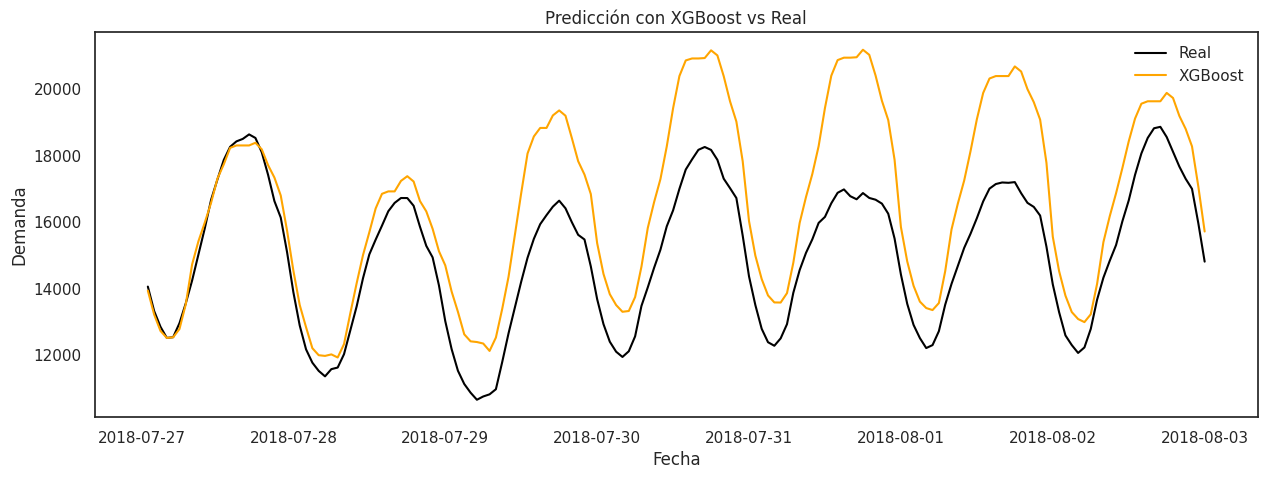

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(test.index, test['demanda'], label='Real', color='black')
plt.plot(test.index, pred_xgb, label='XGBoost', color='orange')
plt.legend(frameon=False)
plt.title("Predicción con XGBoost vs Real")
plt.xlabel("Fecha")
plt.ylabel("Demanda")
plt.show()

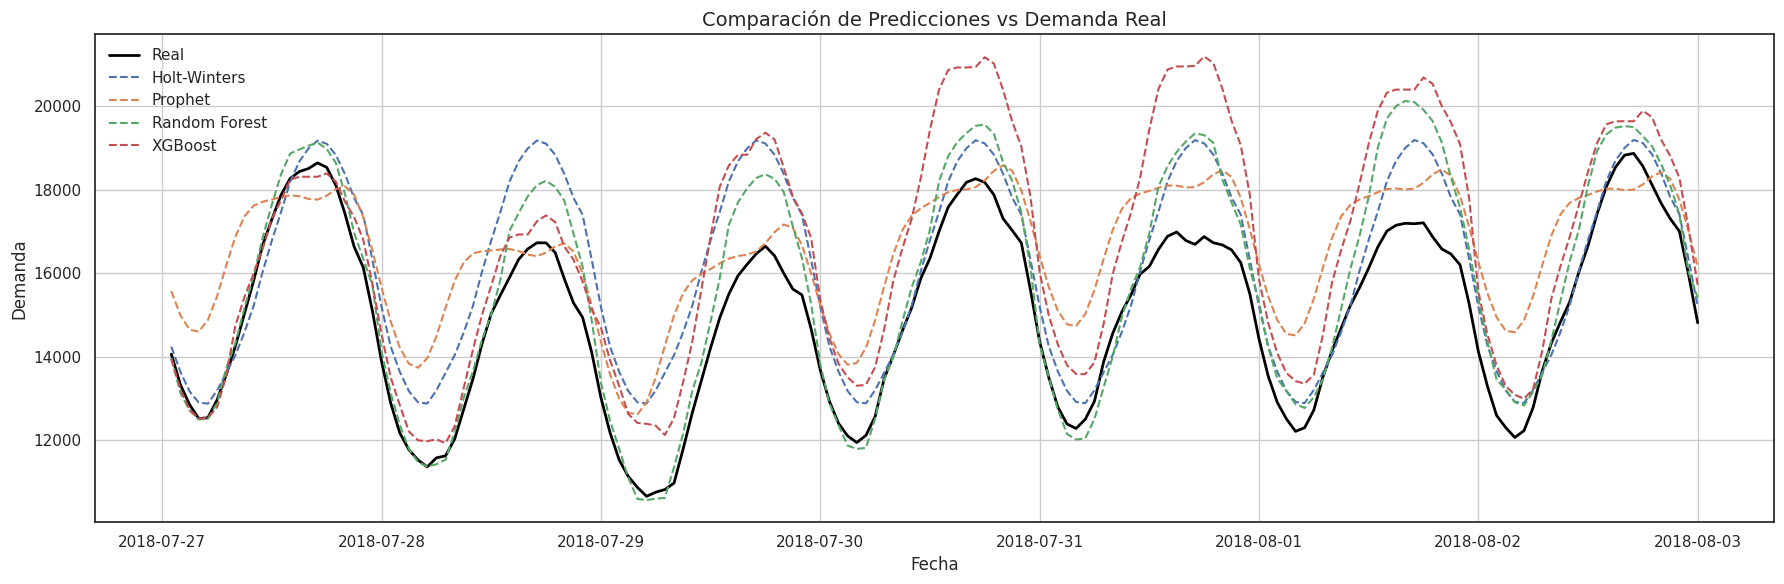

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 6))

# Serie real
plt.plot(test.index, test['demanda'], label='Real', color='black', linewidth=2)

# Predicciones
if pred_hw is not None:
    plt.plot(test.index, pred_hw, label='Holt-Winters', linestyle='--')
if pred_prophet is not None:
    plt.plot(test.index, pred_prophet, label='Prophet', linestyle='--')
if pred_rf is not None:
    plt.plot(test.index, pred_rf, label='Random Forest', linestyle='--')
if pred_xgb is not None:
    plt.plot(test.index, pred_xgb, label='XGBoost', linestyle='--')

# Personalización
plt.title("Comparación de Predicciones vs Demanda Real", fontsize=14)
plt.xlabel("Fecha", fontsize=12)
plt.ylabel("Demanda", fontsize=12)
plt.legend(frameon=False)
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
metricas_hw, metricas_prophet, metricas_rf, metricas_xgb

({'RMSE': np.float64(1422.3959104938963),
  'MAE': 1147.5771608176487,
  'MAPE': np.float64(7.956200001475783)},
 {'RMSE': np.float64(1842.4359225178382),
  'MAE': 1621.0473060563666,
  'MAPE': np.float64(11.733515538442447)},
 {'RMSE': np.float64(1095.0222252865137),
  'MAE': 809.8320238095238,
  'MAPE': np.float64(5.092745847239617)},
 {'RMSE': np.float64(1967.9360253210673),
  'MAE': 1627.4733479817708,
  'MAPE': np.float64(10.686937107176405)})

In [ ]:
df_hw = pd.DataFrame([metricas_hw], index=['HW'])
df_prophet = pd.DataFrame([metricas_prophet], index=['Prophet'])
df_rf = pd.DataFrame([metricas_rf], index=['Random Forest'])
df_xgb = pd.DataFrame([metricas_xgb], index=['XGBoost'])

# Concatenar en un solo DataFrame
df_metricas_modelo_comun = pd.concat([df_hw, df_prophet, df_rf, df_xgb])

# Resetear índice si prefieres tener modelo como columna
df_metricas_modelo_comun = df_metricas_modelo_comun.reset_index().rename(columns={'index': 'Modelo'})

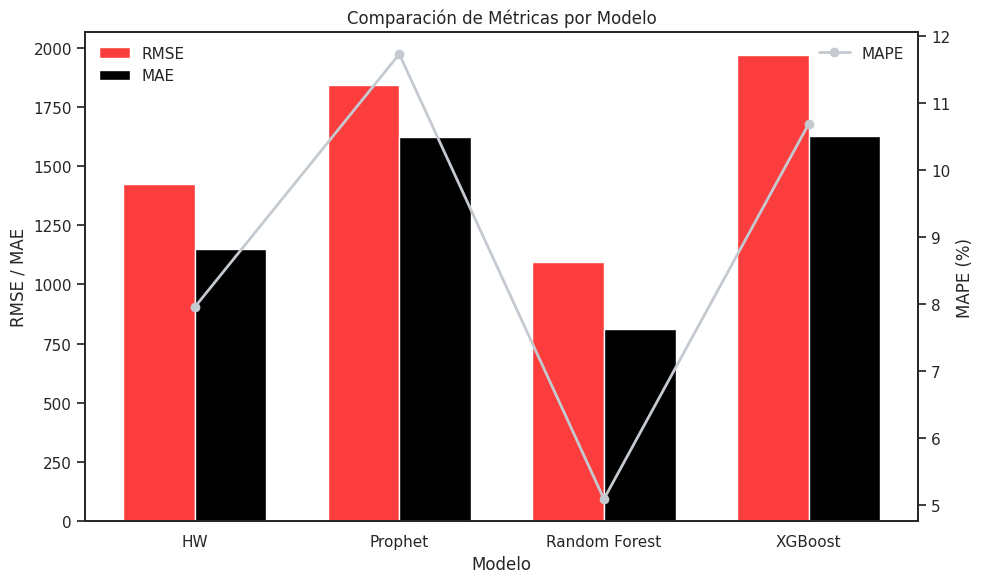

In [ ]:
# Separar los datos
df_melted = df_metricas_modelo_comun.melt(id_vars='Modelo',
                                          value_vars=['RMSE', 'MAE', 'MAPE'],
                                          var_name='Métrica',
                                          value_name='Valor')

# Filtrar para cada eje
df_principal = df_melted[df_melted['Métrica'].isin(['RMSE', 'MAE'])]
df_secundario = df_melted[df_melted['Métrica'] == 'MAPE']

# Crear figura y ejes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Eje principal
ancho = 0.35
modelos = df_metricas_modelo_comun['Modelo']
x = range(len(modelos))

# Agrupar valores por métrica y modelo
rmse_vals = df_metricas_modelo_comun['RMSE']
mae_vals = df_metricas_modelo_comun['MAE']
mape_vals = df_metricas_modelo_comun['MAPE']

# Barras eje principal
ax1.bar([i - ancho/2 for i in x], rmse_vals, width=ancho, label='RMSE', color='#fc3d3d')
ax1.bar([i + ancho/2 for i in x], mae_vals, width=ancho, label='MAE', color='black')
ax1.set_ylabel('RMSE / MAE')
ax1.set_xlabel('Modelo')
ax1.set_xticks(x)
ax1.set_xticklabels(modelos)
ax1.tick_params(axis='y')
ax1.legend(loc='upper left', frameon=False)

# Eje secundario
ax2 = ax1.twinx()
ax2.plot(x, mape_vals, color='#C4CAD0', marker='o', label='MAPE', linewidth=2)
ax2.set_ylabel('MAPE (%)')
ax2.legend(loc='upper right', frameon=False)

plt.title('Comparación de Métricas por Modelo')
plt.tight_layout()
plt.show()

#MODELOS OPTIMIZADOS

## Hot-Winter Optimizado

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error
from joblib import dump
from itertools import product
import os

def evaluar(y_true, y_pred):
    return {
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE": mean_absolute_error(y_true, y_pred),
        "MAPE": np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    }

def guardar_modelo(modelo, ruta_directorio, nombre="modelo_holtwinters.joblib"):
    os.makedirs(ruta_directorio, exist_ok=True)
    ruta_completa = os.path.join(ruta_directorio, nombre)
    dump(modelo, ruta_completa)
    print(f"✅ Modelo guardado en: {ruta_completa}")

def ejecutar_hw_grid_search(train, test, horizonte_pred, ruta_guardado=None):
    mejores_metricas = None
    mejor_modelo = None
    mejor_pred = None
    mejor_params = None

    tendencias = ['add', 'mul', None]
    estacionales = ['add', 'mul', None]
    periodos = [12, 24, 48]  # ajusta según tu frecuencia

    for trend, seasonal, sp in product(tendencias, estacionales, periodos):
        try:
            model = ExponentialSmoothing(
                train['demanda'],
                trend=trend,
                seasonal=seasonal,
                seasonal_periods=sp,
                initialization_method="estimated"
            ).fit()

            pred = model.forecast(horizonte_pred)

            if pred.isna().sum() > 0:
                continue

            metricas = evaluar(test['demanda'], pred)

            if mejores_metricas is None or metricas["RMSE"] < mejores_metricas["RMSE"]:
                mejores_metricas = metricas
                mejor_modelo = model
                mejor_pred = pred
                mejor_params = (trend, seasonal, sp)

        except Exception:
            continue

    if ruta_guardado and mejor_modelo:
        guardar_modelo(mejor_modelo, ruta_guardado)

    return mejores_metricas, mejor_pred, mejor_params, mejor_modelo


In [ ]:
ruta_modelo = "/content/drive/MyDrive/ProyectosPython/Proyecto_Forescasting/modelos/modelooptimizado/holtwinter"

metricas_hw_opt, pred_hw_opt, parametros_opt, mejor_modelo_hw = ejecutar_hw_grid_search(train, test, horizonte_pred, ruta_guardado=ruta_modelo)

print("📈 Métricas del mejor modelo:", metricas_hw_opt)
print("⚙️ Hiperparámetros seleccionados:", parametros_opt)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a support

✅ Modelo guardado en: /content/drive/MyDrive/ProyectosPython/Proyecto_Forescasting/modelos/modelooptimizado/holtwinter/modelo_holtwinters.joblib
📈 Métricas del mejor modelo: {'RMSE': np.float64(1061.904300610315), 'MAE': 885.9332324195252, 'MAPE': nan}
⚙️ Hiperparámetros seleccionados: (None, 'mul', 48)


In [ ]:
ruta_modelo = '/content/drive/MyDrive/ProyectosPython/Proyecto_Forescasting/modelos/modelooptimizado/holtwinter'

# Crear la carpeta si no existe
os.makedirs(ruta_modelo, exist_ok=True)

# Guardar el modelo con nombre 'modelo_xgb.pkl'
joblib.dump((metricas_hw_opt, pred_hw_opt, parametros_opt, mejor_modelo_hw), os.path.join(ruta_modelo, 'modelo_completo_hw_opt.pkl'))

['/content/drive/MyDrive/ProyectosPython/Proyecto_Forescasting/modelos/modelooptimizado/holtwinter/modelo_completo_hw_opt.pkl']

##Prophe optimizado

In [ ]:
from prophet import Prophet
from sklearn.metrics import mean_squared_error
import numpy as np
import warnings
import itertools

def ejecutar_modelo_prophet(train, test, horizonte_pred):
    try:
        df_prophet = train.reset_index()[['fecha', 'demanda']].rename(columns={'fecha': 'ds', 'demanda': 'y'})

        # Parrilla de combinaciones
        modos = ['additive', 'multiplicative']
        cps = [0.001, 0.01, 0.05, 0.1]  # changepoint_prior_scale
        sps = [1, 5, 10, 15]            # seasonality_prior_scale

        combinaciones = list(itertools.product(modos, cps, sps))

        mejor_metricas = {"RMSE": np.inf}
        mejor_pred = None

        for modo, cp, sp in combinaciones:
            try:
                model = Prophet(
                    seasonality_mode=modo,
                    changepoint_prior_scale=cp,
                    seasonality_prior_scale=sp,
                    daily_seasonality=True,
                    weekly_seasonality=True
                )
                model.fit(df_prophet)

                future = model.make_future_dataframe(periods=horizonte_pred, freq='h')
                forecast = model.predict(future)
                pred_prophet = forecast.set_index('ds').loc[test.index, 'yhat']

                if pred_prophet.isna().sum() > 0:
                    continue

                rmse = np.sqrt(mean_squared_error(test['demanda'], pred_prophet))
                metricas = evaluar(test['demanda'], pred_prophet)

                if rmse < mejor_metricas['RMSE']:
                    mejor_metricas = metricas
                    mejor_pred = pred_prophet
                    mejor_modelo = model

            except Exception as e:
                warnings.warn(f"Falló config Prophet: modo={modo}, cp={cp}, sp={sp} -> {e}")
                continue

        if mejor_pred is None:
            print("No se encontró una configuración válida para Prophet.")
            return {"RMSE": np.nan, "MAE": np.nan, "MAPE": np.nan}, None

        print("Mejor Prophet - modo:", modo, ", cp:", cp, ", sp:", sp)
        print("Métricas:", mejor_metricas)
        return mejor_metricas, mejor_pred, mejor_modelo

    except Exception as e:
        print(f"Error general en Prophet: {e}")
        return {"RMSE": np.nan, "MAE": np.nan, "MAPE": np.nan}, None


In [ ]:
metricas_prophet_opt, pred_prophet_opt, modelo_prophet_optimizado_opt = ejecutar_modelo_prophet(train, test, horizonte_pred)

DEBUG:cmdstanpy:input tempfile: /tmp/tmph0nts1cs/nrw6ywqj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph0nts1cs/164sf6g6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32388', 'data', 'file=/tmp/tmph0nts1cs/nrw6ywqj.json', 'init=/tmp/tmph0nts1cs/164sf6g6.json', 'output', 'file=/tmp/tmph0nts1cs/prophet_modelchjvy_on/prophet_model-20250630000814.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:08:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:08:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmph0nts1cs/tl7k8kyt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph0nts1cs/zroloeto.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Mejor Prophet - modo: multiplicative , cp: 0.1 , sp: 15
Métricas: {'RMSE': np.float64(1481.971299119818), 'MAE': 1279.3013925731416, 'MAPE': np.float64(9.288743790263112)}


In [ ]:
ruta_modelo = '/content/drive/MyDrive/ProyectosPython/Proyecto_Forescasting/modelos/modelooptimizado/prophet'

# Crear la carpeta si no existe
os.makedirs(ruta_modelo, exist_ok=True)

# Guardar el modelo con nombre 'prophet.pkl'

joblib.dump((metricas_prophet_opt, pred_prophet_opt, modelo_prophet_optimizado_opt), os.path.join(ruta_modelo, 'modelo_completo_prophet_opt.pkl'))

['/content/drive/MyDrive/ProyectosPython/Proyecto_Forescasting/modelos/modelooptimizado/prophet/modelo_completo_prophet_opt.pkl']

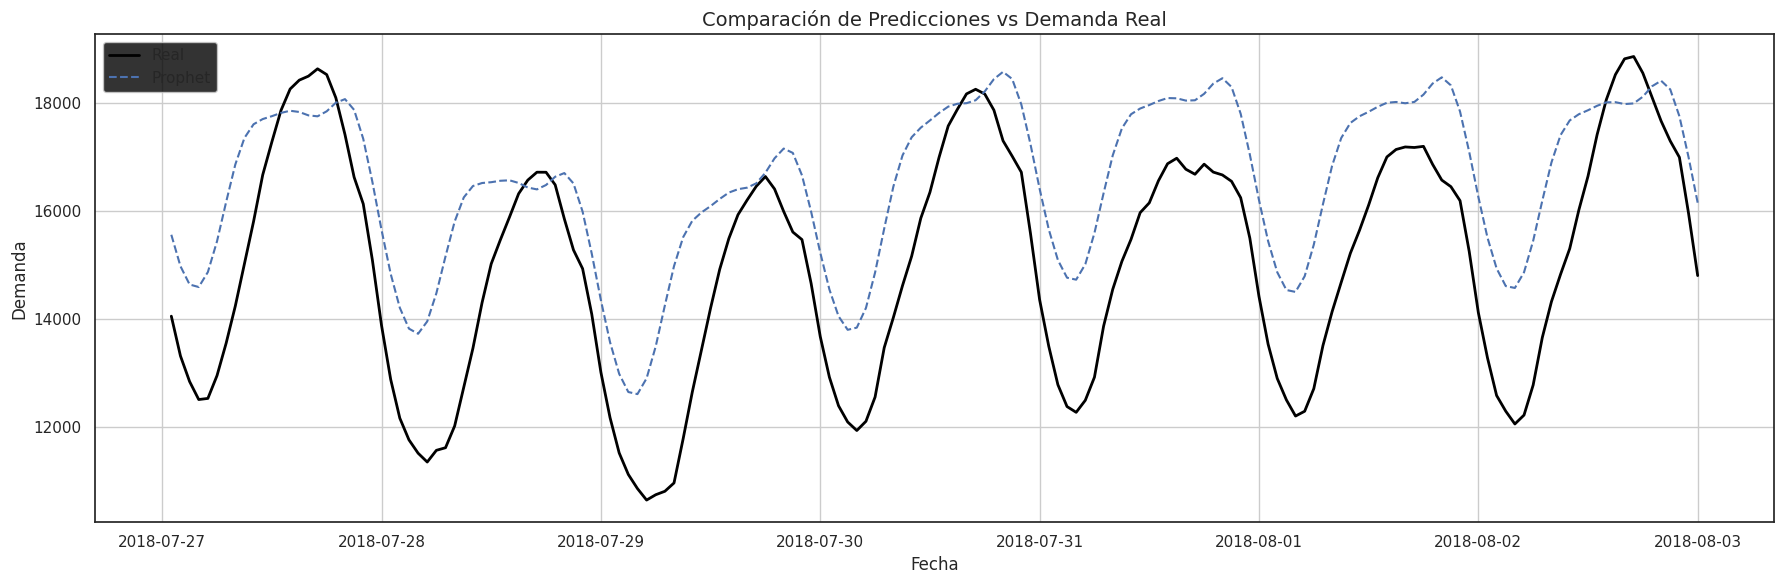

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 6))

# Serie real
plt.plot(test.index, test['demanda'], label='Real', color='black', linewidth=2)

if pred_prophet is not None:
    plt.plot(test.index, pred_prophet, label='Prophet', linestyle='--')

# Personalización
plt.title("Comparación de Predicciones vs Demanda Real", fontsize=14)
plt.xlabel("Fecha", fontsize=12)
plt.ylabel("Demanda", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

##Randomforestoptimizado

In [ ]:
import os
import numpy as np
import joblib
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import randint

def evaluar(y_real, y_pred):
    rmse = np.sqrt(mean_squared_error(y_real, y_pred))  # Corregido
    mae = mean_absolute_error(y_real, y_pred)
    mape = np.mean(np.abs((y_real - y_pred) / y_real)) * 100
    return {"RMSE": rmse, "MAE": mae, "MAPE": mape}

def ejecutar_modelo_random_forest(train, test, features, horizonte_pred):
    try:
        if train[features + ['demanda']].isna().sum().sum() > 0 or test[features].isna().sum().sum() > 0:
            raise ValueError("Hay NaNs en train o test")

        X_train = train[features]
        y_train = train['demanda']
        X_test = test[features]

        param_dist = {
            'n_estimators': randint(50, 200),
            'max_depth': [None, 5, 10, 20],
            'min_samples_split': randint(2, 10),
            'min_samples_leaf': randint(1, 10),
            'max_features': ['sqrt', 'log2', None]  # corregido
        }

        modelo_base = RandomForestRegressor(random_state=42)
        random_search = RandomizedSearchCV(
            modelo_base,
            param_distributions=param_dist,
            n_iter=30,
            cv=3,
            verbose=1,
            random_state=42,
            n_jobs=-1
        )
        random_search.fit(X_train, y_train)

        mejor_modelo_rf = random_search.best_estimator_
        pred_rf = mejor_modelo_rf.predict(X_test)

        metricas_rf = evaluar(test['demanda'], pred_rf)

        # Crear carpeta si no existe
        path_modelo = '/content/drive/MyDrive/ProyectosPython/Proyecto_Forescasting/modelos/randomforest'
        os.makedirs(path_modelo, exist_ok=True)

        # Guardar modelo
        joblib.dump(mejor_modelo_rf, os.path.join(path_modelo, 'modelo_random_forest.pkl'))

        return metricas_rf, pred_rf, mejor_modelo_rf

    except Exception as e:
        print(f"⚠️ Error en Random Forest: {e}")
        return {"RMSE": np.nan, "MAE": np.nan, "MAPE": np.nan}, None, None

# Usar la función
features = ['anio', 'mes', 'dia', 'hora', 'día_semana',
            'es_fin_de_semana', 'periodo_dia', 'semana', 'trimestre',
            'Cuatrimestre', 'semestre', 'es_bisiesto', 'es_feriado']

metricas_rf, pred_rf, modelo_rf_optimizado = ejecutar_modelo_random_forest(train, test, features, horizonte_pred)


# Lista de features
features = ['anio', 'mes', 'dia', 'hora', 'día_semana',
            'es_fin_de_semana', 'periodo_dia', 'semana', 'trimestre',
            'Cuatrimestre', 'semestre', 'es_bisiesto', 'es_feriado']

# Ejecutar
metricas_rf_opt, pred_rf_opt, modelo_rf_optimizado_opt = ejecutar_modelo_random_forest(train, test, features, horizonte_pred)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Fitting 3 folds for each of 30 candidates, totalling 90 fits


In [ ]:
ruta_modelo = '/content/drive/MyDrive/ProyectosPython/Proyecto_Forescasting/modelos/modelooptimizado/randomforest'

# Crear la carpeta si no existe
os.makedirs(ruta_modelo, exist_ok=True)

# Guardar el modelo con nombre 'modelo_xgb.pkl'
joblib.dump((metricas_rf_opt, pred_rf_opt, modelo_rf_optimizado_opt), os.path.join(ruta_modelo, 'modelo_completo_rf_optimizado_opt.pkl'))

['/content/drive/MyDrive/ProyectosPython/Proyecto_Forescasting/modelos/modelooptimizado/randomforest/modelo_completo_rf_optimizado_opt.pkl']

##XGBoots optimizado

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
import numpy as np

def ejecutar_modelo_xgboost_cv(train, test, features, horizonte_pred):
    try:
        if train[features + ['demanda']].isna().sum().sum() > 0 or test[features].isna().sum().sum() > 0:
            raise ValueError("Hay NaNs en train o test")

        X_train = train[features]
        y_train = train['demanda']
        X_test = test[features]

        # Hiperparámetros para búsqueda
        param_grid = {
            'n_estimators': [50, 100],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.05, 0.1],
            'subsample': [0.8, 1],
            'colsample_bytree': [0.8, 1]
        }

        # Validación cruzada temporal (Time Series)
        tscv = TimeSeriesSplit(n_splits=3)

        modelo_base = XGBRegressor(random_state=42)
        grid_search = GridSearchCV(
            estimator=modelo_base,
            param_grid=param_grid,
            scoring='neg_root_mean_squared_error',  # Puedes cambiar a 'neg_mean_absolute_error' si prefieres
            cv=tscv,
            verbose=0,
            n_jobs=-1
        )

        # Entrenamiento y búsqueda
        grid_search.fit(X_train, y_train)
        mejor_modelo = grid_search.best_estimator_

        # Predicción con mejor modelo
        pred_xgb = mejor_modelo.predict(X_test)

        # Evaluación
        metricas_xgb = evaluar(test['demanda'], pred_xgb)

        print(f"✅ Mejor configuración: {grid_search.best_params_}")
        return metricas_xgb, pred_xgb, mejor_modelo

    except Exception as e:
        print(f"⚠️ Error en XGBoost CV: {e}")
        return {"RMSE": np.nan, "MAE": np.nan, "MAPE": np.nan}, None, None


In [ ]:
metricas_xgb_opt, pred_xgb_opt, modelo_xgb_cv_opt = ejecutar_modelo_xgboost_cv(train, test, features, horizonte_pred)

✅ Mejor configuración: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 50, 'subsample': 1}


In [ ]:
ruta_modelo = '/content/drive/MyDrive/ProyectosPython/Proyecto_Forescasting/modelos/modelooptimizado/xgboots'

# Crear la carpeta si no existe
os.makedirs(ruta_modelo, exist_ok=True)

# Guardar el modelo con nombre 'modelo_xgb.pkl'
joblib.dump((metricas_xgb_opt, pred_xgb_opt, modelo_xgb_cv_opt), os.path.join(ruta_modelo, 'modelo_completo_xgb_opt.pkl'))

['/content/drive/MyDrive/ProyectosPython/Proyecto_Forescasting/modelos/modelooptimizado/xgboots/modelo_completo_xgb_opt.pkl']

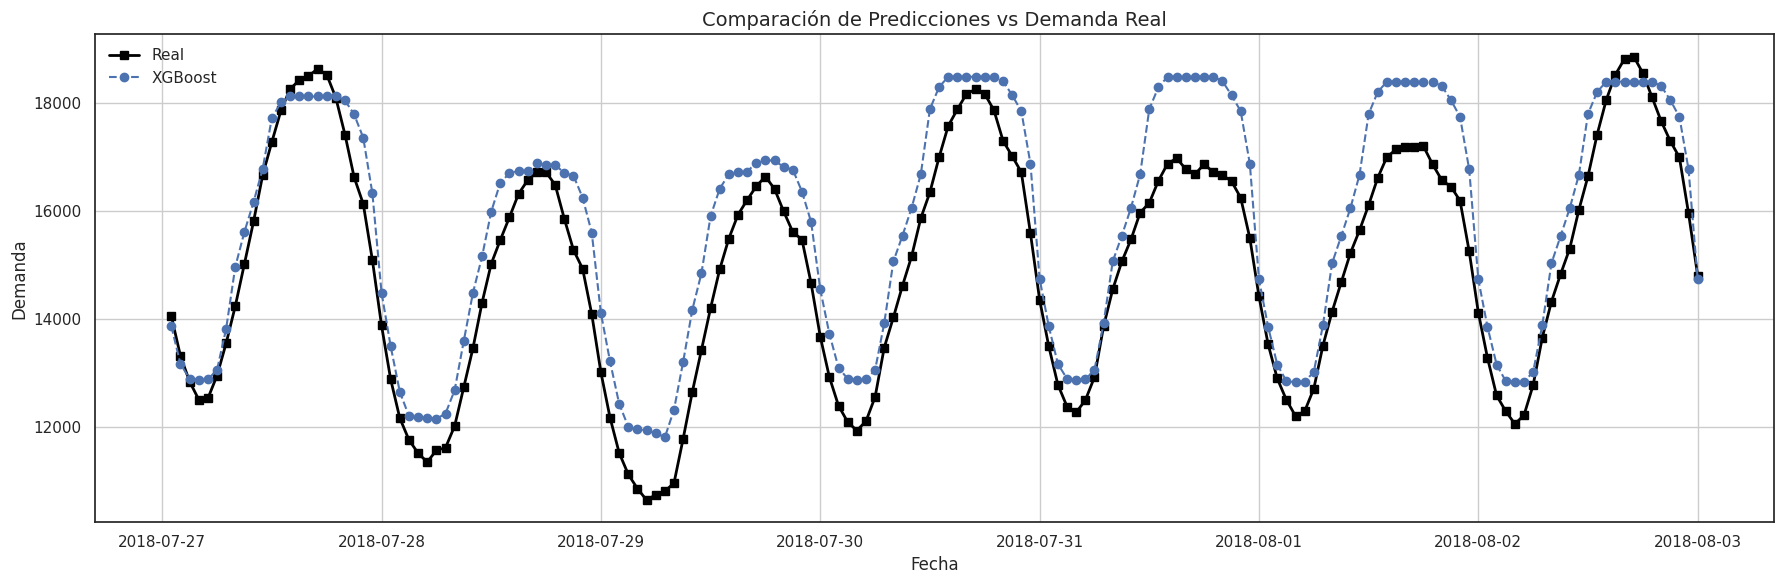

In [ ]:
plt.figure(figsize=(18, 6))

# Serie real
plt.plot(test.index, test['demanda'], label='Real', color='black', linewidth=2, marker="s")

# Predicciones
if pred_xgb is not None:
    plt.plot(test.index, pred_xgb_opt, label='XGBoost', linestyle='--', marker="o")

# Personalización
plt.title("Comparación de Predicciones vs Demanda Real", fontsize=14)
plt.xlabel("Fecha", fontsize=12)
plt.ylabel("Demanda", fontsize=12)
plt.legend(frameon=False)
plt.grid(True)
plt.tight_layout()
plt.show()

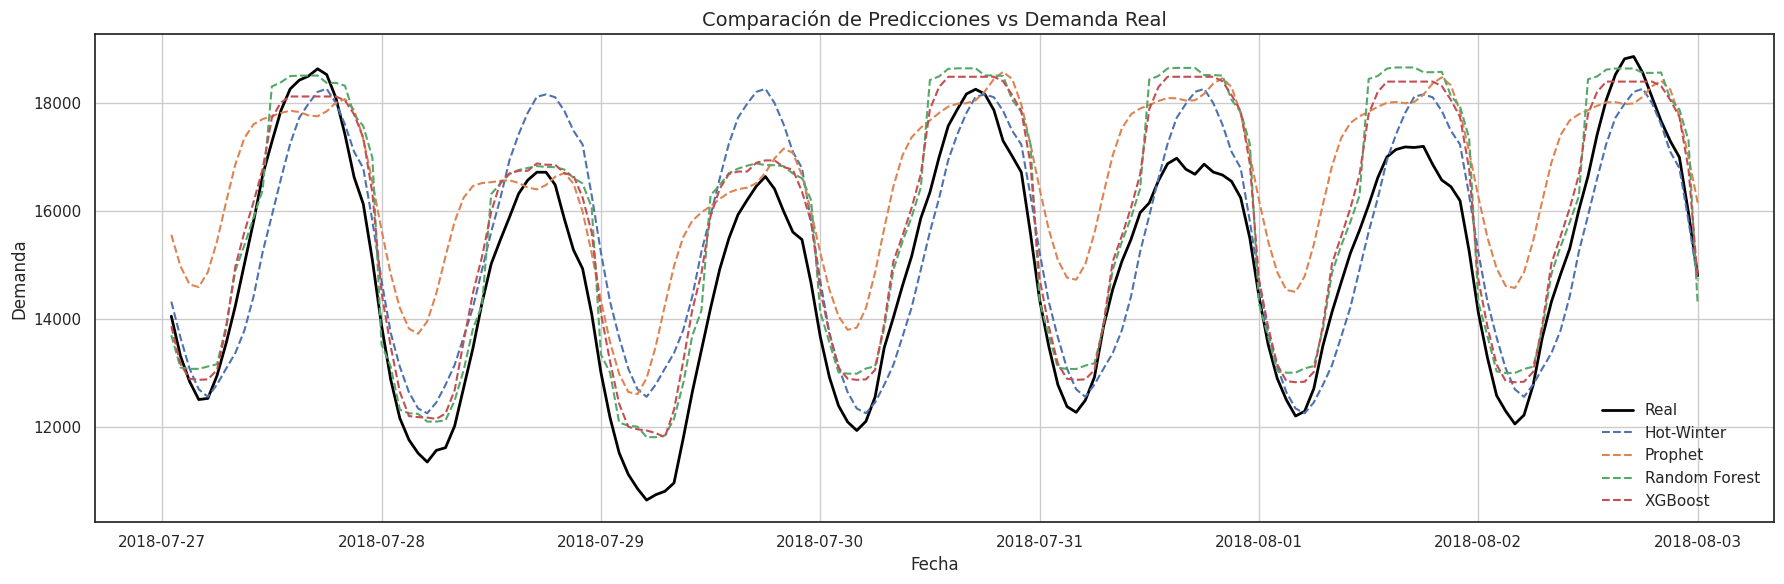

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 6))

# Serie real
plt.plot(test.index, test['demanda'], label='Real', color='black', linewidth=2)

# Predicciones
if pred_hw_opt is not None:
    plt.plot(test.index, pred_hw_opt, label='Hot-Winter', linestyle='--')
if pred_prophet is not None:
    plt.plot(test.index, pred_prophet, label='Prophet', linestyle='--')
if pred_rf is not None:
    plt.plot(test.index, pred_rf_opt, label='Random Forest', linestyle='--')
if pred_xgb is not None:
    plt.plot(test.index, pred_xgb_opt, label='XGBoost', linestyle='--')

# Personalización
plt.title("Comparación de Predicciones vs Demanda Real", fontsize=14)
plt.xlabel("Fecha", fontsize=12)
plt.ylabel("Demanda", fontsize=12)
plt.legend(frameon=False)
plt.grid(True)
plt.tight_layout()
plt.show()

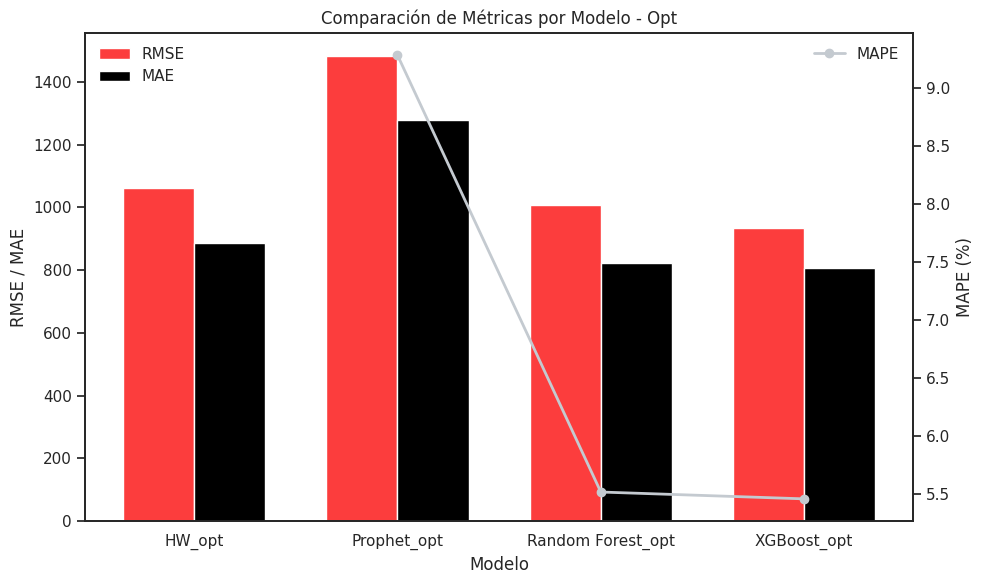

In [ ]:
df_hw_opt = pd.DataFrame([metricas_hw_opt], index=['HW_opt'])
df_prophet_opt = pd.DataFrame([metricas_prophet_opt], index=['Prophet_opt'])
df_rf_opt = pd.DataFrame([metricas_rf_opt], index=['Random Forest_opt'])
df_xgb_opt = pd.DataFrame([metricas_xgb_opt], index=['XGBoost_opt'])


# Concatenar en un solo DataFrame
df_metricas_modelo_comun_opt = pd.concat([df_hw_opt, df_prophet_opt, df_rf_opt, df_xgb_opt])

# Resetear índice si prefieres tener modelo como columna
df_metricas_modelo_comun_opt = df_metricas_modelo_comun_opt.reset_index().rename(columns={'index': 'Modelo_opt'})




# Separar los datos
df_melted_opt = df_metricas_modelo_comun_opt.melt(id_vars='Modelo_opt',
                                          value_vars=['RMSE', 'MAE', 'MAPE'],
                                          var_name='Métrica',
                                          value_name='Valor')

# Filtrar para cada eje
df_principal_opt = df_melted_opt[df_melted_opt['Métrica'].isin(['RMSE', 'MAE'])]
df_secundario_opt = df_melted_opt[df_melted_opt['Métrica'] == 'MAPE']

# Crear figura y ejes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Eje principal
ancho = 0.35
modelos = df_metricas_modelo_comun_opt['Modelo_opt']
x = range(len(modelos))

# Agrupar valores por métrica y modelo
rmse_vals_opt = df_metricas_modelo_comun_opt['RMSE']
mae_vals_opt = df_metricas_modelo_comun_opt['MAE']
mape_vals_opt = df_metricas_modelo_comun_opt['MAPE']

# Barras eje principal
ax1.bar([i - ancho/2 for i in x], rmse_vals_opt, width=ancho, label='RMSE', color='#fc3d3d')
ax1.bar([i + ancho/2 for i in x], mae_vals_opt, width=ancho, label='MAE', color='black')
ax1.set_ylabel('RMSE / MAE')
ax1.set_xlabel('Modelo')
ax1.set_xticks(x)
ax1.set_xticklabels(modelos)
ax1.tick_params(axis='y')
ax1.legend(loc='upper left', frameon=False)

# Eje secundario
ax2 = ax1.twinx()
ax2.plot(x, mape_vals_opt, color='#C4CAD0', marker='o', label='MAPE', linewidth=2)
ax2.set_ylabel('MAPE (%)')
ax2.legend(loc='upper right', frameon=False)

plt.title('Comparación de Métricas por Modelo - Opt')
plt.tight_layout()
plt.show()

In [ ]:
df_metricas_modelo_comun_opt

Modelo         RMSE          MAE       MAPE
0             HW  1422.395910  1147.577161   7.956200
1        Prophet  1842.435923  1621.047306  11.733516
2  Random Forest  1095.022225   809.832024   5.092746
3        XGBoost  1967.936025  1627.473348  10.686937

# Deep Learning

## LSTM para serie temporales

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

def crear_dataset_lstm(data, features, target, look_back=7):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[features].iloc[i:i + look_back].values)
        y.append(data[target].iloc[i + look_back])
    return np.array(X), np.array(y)

def ejecutar_modelo_lstm(train, test, features, horizonte_pred, look_back=7, epochs=20):
    try:
        # Crear datos para LSTM
        X_train, y_train = crear_dataset_lstm(train, features, 'demanda', look_back)
        X_test, y_test = crear_dataset_lstm(test, features, 'demanda', look_back)

        # Definir modelo
        model = Sequential()
        model.add(LSTM(32, input_shape=(look_back, len(features))))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')

        # Entrenar
        model.fit(X_train, y_train, epochs=epochs, verbose=0)

        # Predecir
        pred = model.predict(X_test).flatten()

        # Evaluar (en escala normalizada)
        metricas = evaluar(y_test, pred)

        return metricas, pred, model

    except Exception as e:
        print(f"⚠️ Error en LSTM: {e}")
        return {"RMSE": np.nan, "MAE": np.nan, "MAPE": np.nan}, None, None

In [ ]:
features = features_minimos
metricas_lstm, pred_lstm, modelo_lstm = ejecutar_modelo_lstm(train, test, features, horizonte_pred)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt



In [ ]:
df_forecasting.columns

## 🔮 N-BEATS (con neuralforecast)

In [ ]:
import pandas as pd
import numpy as np
from neuralforecast.models import NBEATS
from neuralforecast import NeuralForecast
from neuralforecast.losses.pytorch import RMSE
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 🔧 Función de evaluación
def evaluar(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = (abs((y_true - y_pred) / y_true).mean()) * 100
    return {'RMSE': rmse, 'MAE': mae, 'MAPE': mape}

# 🔧 Preparar dataframe para N-BEATS
def preparar_df_para_nbeats(df_forecasting):
    df = df_forecasting.copy()
    df = df.rename(columns={'fecha': 'ds', 'demanda': 'y'})
    df['unique_id'] = 'serie_1'
    df['ds'] = pd.to_datetime(df['ds'])  # asegúrate que sea datetime
    return df[['unique_id', 'ds', 'y']]

# 🧠 Ejecutar modelo
def ejecutar_modelo_nbeats(df_forecasting, horizonte_pred, dias_historia=30):
    try:
        # Asegurarse de que las fechas estén en orden
        df_forecasting = df_forecasting.sort_values('fecha').reset_index(drop=True)

        # Convertir días de historial a pasos (asumiendo frecuencia horaria)
        pasos_historia = dias_historia * 24

        # Preparar datos para entrenamiento
        df_entrenamiento = preparar_df_para_nbeats(df_forecasting.iloc[-(pasos_historia + horizonte_pred):-horizonte_pred])

        # Inicializar modelo
      #  model = NBEATS(h=horizonte_pred, input_size=30, loss=RMSE(), max_steps=100)

        model = NBEATS(
            h=168,
            input_size=48,
            n_blocks=[2, 2, 2],
            mlp_units=[[128, 128], [128, 128], [128, 128]],
            stack_types=['identity', 'trend', 'seasonality'],
            loss=RMSE(),
            max_steps=100,
        )



        nf = NeuralForecast(models=[model], freq='h')  # Frecuencia horaria
        nf.fit(df_entrenamiento)

        # Realizar predicción
        df_pred = nf.predict()

        # Obtener valores reales del mismo rango que la predicción
        df_valores_reales = preparar_df_para_nbeats(df_forecasting.iloc[-horizonte_pred:])
        y_true = df_valores_reales['y'].values
        y_pred = df_pred['NBEATS'].values

        metricas = evaluar(y_true, y_pred)

        return metricas, df_valores_reales, df_pred, nf

    except Exception as e:
        print(f"⚠️ Error en N-BEATS: {e}")
        return {"RMSE": None, "MAE": None, "MAPE": None}, None, None, None


In [ ]:
# Asegúrate que tus datos estén ordenados y en datetime
df_forecasting['fecha'] = pd.to_datetime(df_forecasting['fecha'])
df_forecasting = df_forecasting.sort_values('fecha').reset_index(drop=True)

# Define el horizonte de predicción (por ejemplo, 7 días = 168 horas)
horizonte_pred = 7*24

# Ejecutar el modelo
metricas, valores_reales, predicciones, modelo_nbeats = ejecutar_modelo_nbeats(df_forecasting, horizonte_pred)

# Ver resultados
print("Métricas:", metricas)

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | RMSE          | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 710 K  | train
-------------------------------------------------------
564 K     Trainable params
145 K     Non-trainable params
710 K     Total params
2.840     Total estimated model params size (MB)
58        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Métricas: {'RMSE': np.float64(1378.8179897499722), 'MAE': 1031.287330264137, 'MAPE': np.float64(7.027294847865735)}


In [ ]:
valores_reales

unique_id                  ds        y
121105   serie_1 2018-07-27 01:00:00  14057.0
121106   serie_1 2018-07-27 02:00:00  13320.0
121107   serie_1 2018-07-27 03:00:00  12846.0
121108   serie_1 2018-07-27 04:00:00  12512.0
121109   serie_1 2018-07-27 05:00:00  12533.0
...          ...                 ...      ...
121268   serie_1 2018-08-02 20:00:00  17673.0
121269   serie_1 2018-08-02 21:00:00  17303.0
121270   serie_1 2018-08-02 22:00:00  17001.0
121271   serie_1 2018-08-02 23:00:00  15964.0
121272   serie_1 2018-08-03 00:00:00  14809.0

[168 rows x 3 columns]

In [ ]:
predicciones

unique_id                  ds        NBEATS
0     serie_1 2018-07-27 01:00:00  14055.799805
1     serie_1 2018-07-27 02:00:00  13189.372070
2     serie_1 2018-07-27 03:00:00  12370.264648
3     serie_1 2018-07-27 04:00:00  12275.095703
4     serie_1 2018-07-27 05:00:00  12536.797852
..        ...                 ...           ...
163   serie_1 2018-08-02 20:00:00  17602.074219
164   serie_1 2018-08-02 21:00:00  16956.259766
165   serie_1 2018-08-02 22:00:00  16181.534180
166   serie_1 2018-08-02 23:00:00  15333.678711
167   serie_1 2018-08-03 00:00:00  14362.351562

[168 rows x 3 columns]

In [ ]:
import matplotlib.pyplot as plt
def graficar_resultados(df_valores_reales, df_pred):
    df_plot = df_valores_reales.copy()
    df_plot['Predicho'] = df_pred['NBEATS'].values

    plt.figure(figsize=(15, 5))
    plt.plot(df_plot['ds'], df_plot['y'], label='Real', color='black')
    plt.plot(df_plot['ds'], df_plot['Predicho'], label='Predicción NBeats', linestyle='--', color='blue')
    plt.xlabel('Fecha')
    plt.ylabel('Demanda')
    plt.title('Comparación: Real vs Predicción (N-BEATS)')
    plt.legend(frameon=False)  # Sin fondo
    plt.grid(False)
    plt.tight_layout()
    plt.show()


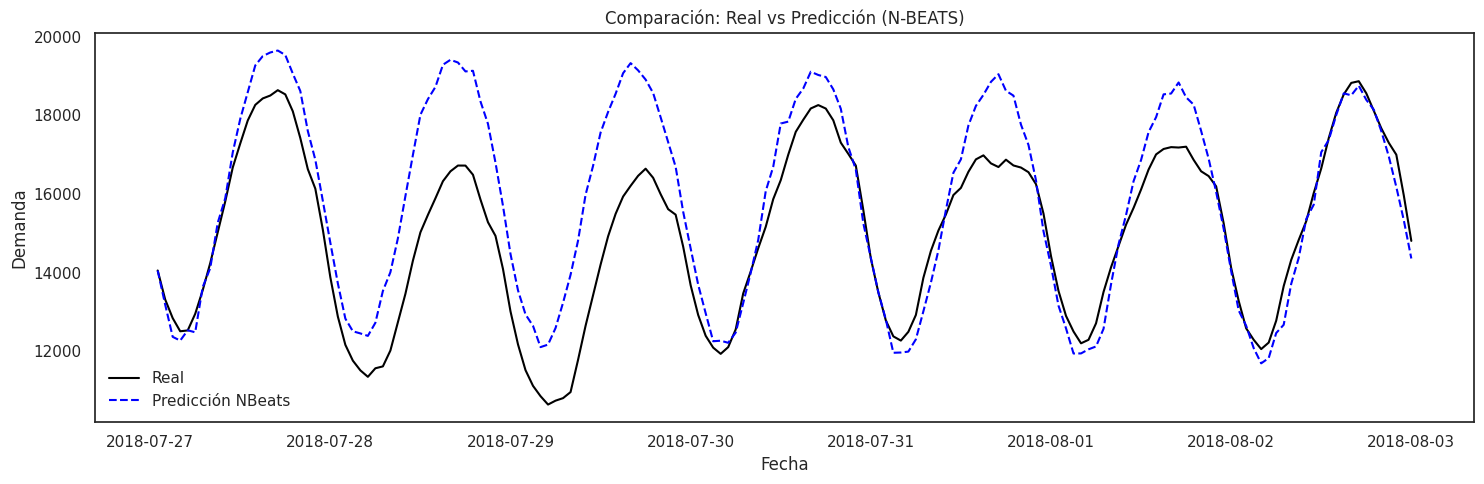

In [ ]:
graficar_resultados(valores_reales, predicciones)

##Nbeats Optimizado

INFO:lightning_fabric.utilities.seed:Seed set to 1


➡️ Entrenando: input_size=24, mlp_units=128, n_blocks=2


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | RMSE          | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 669 K  | train
-------------------------------------------------------
539 K     Trainable params
129 K     Non-trainable params
669 K     Total params
2.677     Total estimated model params size (MB)
58        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | RMSE          | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 1.0 M  | train
-------------------------------------------------------
809 K     Trainable params
194 K     Non-trainable params
1.0 M     Total params
4.016     Total estimated model params size (MB)
85        Modules in train mode
0         Modules in eval mode


➡️ Entrenando: input_size=24, mlp_units=128, n_blocks=3


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | RMSE          | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 1.8 M  | train
-------------------------------------------------------
1.7 M     Trainable params
129 K     Non-trainable params
1.8 M     Total params
7.189     Total estimated model params size (MB)
58        Modules in train mode
0         Modules in eval mode


➡️ Entrenando: input_size=24, mlp_units=256, n_blocks=2


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | RMSE          | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.7 M  | train
-------------------------------------------------------
2.5 M     Trainable params
194 K     Non-trainable params
2.7 M     Total params
10.783    Total estimated model params size (MB)
85        Modules in train mode
0         Modules in eval mode


➡️ Entrenando: input_size=24, mlp_units=256, n_blocks=3


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | RMSE          | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 710 K  | train
-------------------------------------------------------
564 K     Trainable params
145 K     Non-trainable params
710 K     Total params
2.840     Total estimated model params size (MB)
58        Modules in train mode
0         Modules in eval mode


➡️ Entrenando: input_size=48, mlp_units=128, n_blocks=2


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | RMSE          | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 1.1 M  | train
-------------------------------------------------------
846 K     Trainable params
218 K     Non-trainable params
1.1 M     Total params
4.260     Total estimated model params size (MB)
85        Modules in train mode
0         Modules in eval mode


➡️ Entrenando: input_size=48, mlp_units=128, n_blocks=3


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | RMSE          | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 1.9 M  | train
-------------------------------------------------------
1.7 M     Trainable params
145 K     Non-trainable params
1.9 M     Total params
7.450     Total estimated model params size (MB)
58        Modules in train mode
0         Modules in eval mode


➡️ Entrenando: input_size=48, mlp_units=256, n_blocks=2


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | RMSE          | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.8 M  | train
-------------------------------------------------------
2.6 M     Trainable params
218 K     Non-trainable params
2.8 M     Total params
11.175    Total estimated model params size (MB)
85        Modules in train mode
0         Modules in eval mode


➡️ Entrenando: input_size=48, mlp_units=256, n_blocks=3


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

✅ Mejor config: input=48, mlp_units=128, n_blocks=2
📊 Métricas: RMSE=1378.82, MAE=1031.29, MAPE=7.03%


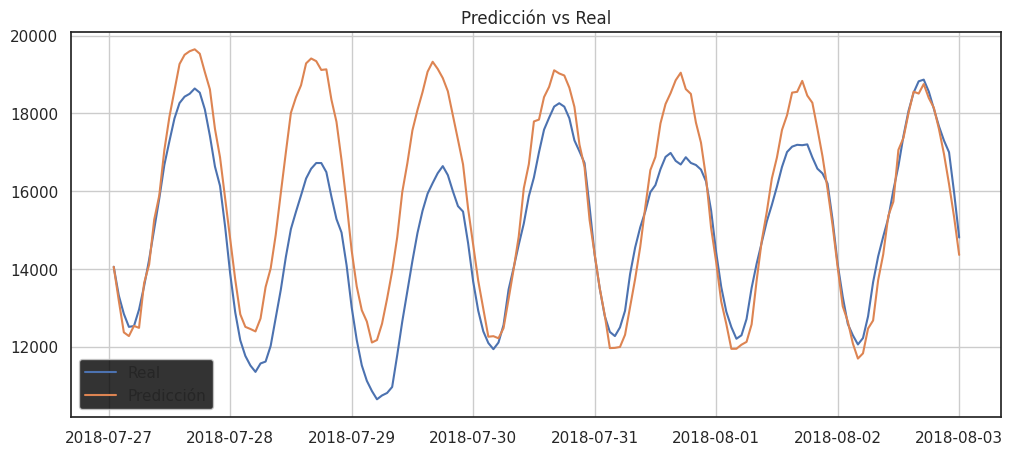

In [ ]:
import pandas as pd
import numpy as np
from neuralforecast.models import NBEATS
from neuralforecast import NeuralForecast
from neuralforecast.losses.pytorch import RMSE
from sklearn.metrics import mean_squared_error, mean_absolute_error
from itertools import product
import matplotlib.pyplot as plt

# 📊 Función de evaluación
def evaluar(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = (np.abs((y_true - y_pred) / y_true).mean()) * 100
    return {'RMSE': rmse, 'MAE': mae, 'MAPE': mape}

# 🛠️ Preprocesamiento para N-BEATS
def preparar_df_para_nbeats(df):
    df = df.copy()
    df = df.rename(columns={'fecha': 'ds', 'demanda': 'y'})
    df['ds'] = pd.to_datetime(df['ds'])
    df['unique_id'] = 'serie_1'
    return df[['unique_id', 'ds', 'y']]

# 📈 Visualización
def graficar_resultados(y_real, y_pred):
    plt.figure(figsize=(12,5))
    plt.plot(y_real['ds'], y_real['y'], label='Real')
    plt.plot(y_pred['ds'], y_pred['NBEATS'], label='Predicción')
    plt.legend()
    plt.grid()
    plt.title('Predicción vs Real')
    plt.show()

def gridsearch_nbeats(df_forecasting, horizonte_pred=168, dias_historia=30):
    df_forecasting = df_forecasting.sort_values('fecha').reset_index(drop=True)
    pasos_historia = dias_historia * 24

    df_entrenamiento = preparar_df_para_nbeats(
        df_forecasting.iloc[-(pasos_historia + horizonte_pred):-horizonte_pred]
    )
    df_valores_reales = preparar_df_para_nbeats(
        df_forecasting.iloc[-horizonte_pred:]
    )
    y_true = df_valores_reales['y'].values

    input_sizes = [24, 48]
    mlp_units_list = [128, 256]
    n_blocks_list = [2, 3]

    resultados = []

    for input_size, mlp_units, n_blocks in product(input_sizes, mlp_units_list, n_blocks_list):
        try:
            print(f"➡️ Entrenando: input_size={input_size}, mlp_units={mlp_units}, n_blocks={n_blocks}")

            model = NBEATS(
                h=horizonte_pred,
                input_size=input_size,
                loss=RMSE(),
                max_steps=100,
                n_blocks=[n_blocks]*3,                         # ✅ tres stacks
                mlp_units=[[mlp_units]*2]*3,                   # ✅ lista de listas por stack
                stack_types=['identity', 'trend', 'seasonality']
            )

            nf = NeuralForecast(models=[model], freq='h')
            nf.fit(df_entrenamiento)
            df_pred = nf.predict()

            y_pred = df_pred['NBEATS'].values
            metricas = evaluar(y_true, y_pred)

            resultados.append({
                'input_size': input_size,
                'mlp_units': mlp_units,
                'n_blocks': n_blocks,
                'RMSE': metricas['RMSE'],
                'MAE': metricas['MAE'],
                'MAPE': metricas['MAPE'],
                'modelo': nf,
                'predicciones': df_pred,
                'valores_reales': df_valores_reales
            })

        except Exception as e:
            print(f"⚠️ Error con combinación input_size={input_size}, mlp_units={mlp_units}, n_blocks={n_blocks}: {e}")
            continue

    if not resultados:
        print("❌ No se pudo entrenar ningún modelo.")
        return []

    # Ordena por MAPE ascendente (menor es mejor)
    return sorted(resultados, key=lambda x: x['MAPE']), nf


# ⚙️ Ajusta estos valores
horizonte_pred = 24 * 7  # 7 días = 168 horas
dias_historia = 30

# 🧪 Ejecuta el tuning
resultados, nf = gridsearch_nbeats(df_forecasting, horizonte_pred, dias_historia)

# 📈 Visualiza el mejor modelo
if resultados:
    mejor = resultados[0]
    print(f"✅ Mejor config: input={mejor['input_size']}, mlp_units={mejor['mlp_units']}, n_blocks={mejor['n_blocks']}")
    print(f"📊 Métricas: RMSE={mejor['RMSE']:.2f}, MAE={mejor['MAE']:.2f}, MAPE={mejor['MAPE']:.2f}%")
    graficar_resultados(mejor['valores_reales'], mejor['predicciones'])
else:
    print("❌ No se obtuvieron resultados.")


In [ ]:
# Extraer solo las métricas (y opcionalmente parámetros del modelo)
df_metricas_deeplearning = pd.DataFrame([{
    "Modelo" : 'NBEATS',
    'RMSE': mejor['RMSE'],
    'MAE': mejor['MAE'],
    'MAPE': mejor['MAPE']
}])

# Mostrar el DataFrame resultant-e
df_metricas_deeplearning

Modelo        RMSE         MAE      MAPE
0  NBEATS  1378.81799  1031.28733  7.027295

In [ ]:
ruta_modelo = '/content/drive/MyDrive/ProyectosPython/Proyecto_Forescasting/modelos/deeplearning'

# Crear la carpeta si no existe
os.makedirs(ruta_modelo, exist_ok=True)

# Guardar el modelo con nombre 'modelo_xgb.pkl'
joblib.dump((df_metricas_deeplearning, mejor['predicciones']['NBEATS'], nf), os.path.join(ruta_modelo, 'modelo_completo_nbeats.pkl'))

['/content/drive/MyDrive/ProyectosPython/Proyecto_Forescasting/modelos/deeplearning/modelo_completo_nbeats.pkl']

In [ ]:
df_metricas_deeplearning.columns

Index(['Modelo', 'RMSE', 'MAE', 'MAPE'], dtype='object')

In [ ]:
# 1. Renombrar columna 'Modelo_opt' a 'Modelo'
df_metricas_modelo_comun_opt = df_metricas_modelo_comun_opt.rename(columns={'Modelo_opt': 'Modelo'})

# 2. Agregar columna 'Modelo' a df_metricas_deeplearning si no existe
df_metricas_deeplearning['Modelo'] = 'DeepLearning'  # O cualquier nombre que desees

# 3. Reordenar columnas si es necesario
columnas_orden = ['Modelo', 'RMSE', 'MAE', 'MAPE']
df_metricas_modelo_comun = df_metricas_modelo_comun[columnas_orden]
df_metricas_modelo_comun_opt = df_metricas_modelo_comun_opt[columnas_orden]
df_metricas_deeplearning = df_metricas_deeplearning[columnas_orden]

# 4. Concatenar todos
df_metricas_final = pd.concat([
    df_metricas_modelo_comun,
    df_metricas_modelo_comun_opt,
    df_metricas_deeplearning
], ignore_index=True)

# Resultado
df_metricas_final

Modelo         RMSE          MAE       MAPE
0                 HW  1422.395910  1147.577161   7.956200
1            Prophet  1842.435923  1621.047306  11.733516
2      Random Forest  1095.022225   809.832024   5.092746
3            XGBoost  1967.936025  1627.473348  10.686937
4             HW_opt  1061.904301   885.933232        NaN
5        Prophet_opt  1481.971299  1279.301393   9.288744
6  Random Forest_opt  1008.008406   823.325769   5.519135
7        XGBoost_opt   934.912875   806.432117   5.460229
8       DeepLearning  1378.817990  1031.287330   7.027295

In [ ]:
df_metricas_final = df_metricas_final.sort_values(by='RMSE', ascending=True).reset_index(drop=True)

NameError: name 'df_metricas_final' is not defined

NameError: name 'df_metricas_final' is not defined

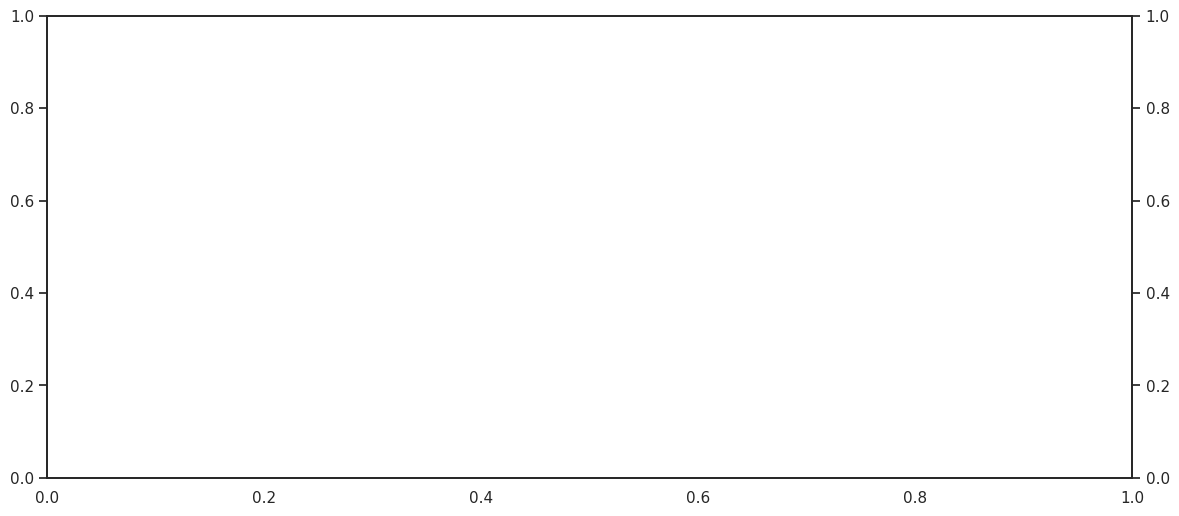

In [ ]:
# Crear figura y ejes
fig, ax1 = plt.subplots(figsize=(14, 6))

# Eje secundario para MAPE
ax2 = ax1.twinx()

# Posiciones de las barras
x = range(len(df_metricas_final))

# Gráficas
ax1.bar(x, df_metricas_final['RMSE'], width=0.3, label='RMSE', align='center', color='steelblue')
ax1.bar([i + 0.3 for i in x], df_metricas_final['MAE'], width=0.3, label='MAE', align='center', color='orange')

# MAPE en eje secundario
ax2.plot(x, df_metricas_final['MAPE'], label='MAPE (%)', color='green', marker='o', linewidth=2)

# Ejes y etiquetas
ax1.set_xlabel('Modelo')
ax1.set_ylabel('RMSE / MAE')
ax2.set_ylabel('MAPE (%)')

# Ticks
ax1.set_xticks([i + 0.15 for i in x])
ax1.set_xticklabels(df_metricas_final['Modelo'], rotation=45)

# Leyendas
ax1.legend(loc='upper left', frameon=False)
ax2.legend(loc='upper right', frameon=False)

# Título
plt.title('Comparación de Modelos: RMSE, MAE y MAPE')

plt.tight_layout()
plt.show()

NameError: name 'pred_hw_opt' is not defined

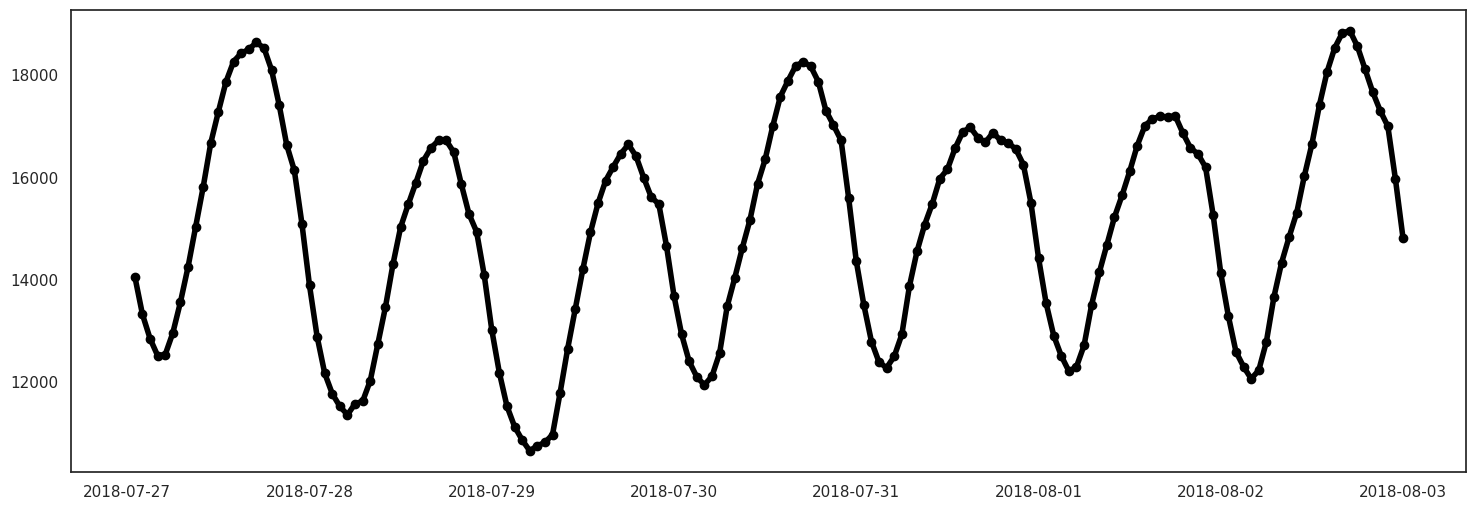

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 6))

# Serie real
plt.plot(test.index, test['demanda'], label='Real', color='black', linewidth=4, marker='o', alpha=1)

# Predicciones sin optimizar
if pred_hw_opt is not None:
    plt.plot(test.index, pred_hw, label='Hot-Winter', linestyle='--', alpha=0.5)
if pred_prophet is not None:
    plt.plot(test.index, pred_prophet, label='Prophet', linestyle='--', alpha=0.5)
if pred_rf is not None:
    plt.plot(test.index, pred_rf, label='Random Forest', linestyle='--', alpha=0.5)
if pred_xgb is not None:
    plt.plot(test.index, pred_xgb, label='XGBoost', linestyle='--', alpha=0.5)

# Predicciones optimizadas
if pred_hw_opt is not None:
    plt.plot(test.index, pred_hw_opt, label='Hot-Winter_OPT', linestyle='--', alpha=0.5)
if pred_prophet is not None:
    plt.plot(test.index, pred_prophet_opt, label='Prophet_OPT', linestyle='--', alpha=0.5)
if pred_rf is not None:
    plt.plot(test.index, pred_rf_opt, label='Random Forest_OPT', linestyle='--', alpha=0.5)
if pred_xgb is not None:
    plt.plot(test.index, pred_xgb_opt, label='XGBoost_OPT', linestyle='-', linewidth=3, color='red', marker='o', alpha=0.8)

# Predicciones NBEATS
plt.plot(test.index, mejor['predicciones']['NBEATS'], label='N-BEATS', linestyle='--', alpha=0.6)

# Personalización
plt.title("Comparación de Predicciones vs Demanda Real", fontsize=14)
plt.xlabel("Fecha", fontsize=12)
plt.ylabel("Demanda", fontsize=12)

# Leyenda ordenada y fuera del gráfico
handles, labels = plt.gca().get_legend_handles_labels()
sorted_handles_labels = sorted(zip(labels, handles), key=lambda x: x[0])
labels, handles = zip(*sorted_handles_labels)
plt.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)

# Quitar grid
plt.grid(axis='y', linestyle='--', linewidth=0.8, alpha=0.9)
plt.tight_layout()
plt.show()